# Projeto Posicionamento Covid

## 1 - Usando GPU Colaborativo (se disponível)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 - Instalando a biblioteca do Hugging Face

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00


In [3]:
# Ajeitando os pacotes da biblioteca transformers

from transformers import BertForSequenceClassification, BertTokenizer, pipeline

## 2 - Banco de dados

In [13]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

df20 = pd.read_csv('/content/drive/MyDrive/Projeto Posicionamento COVID/tweets_annotated.csv')

df20 = df20[(df20['date_post'] >= "2020-01-01") & (df20['date_post']< "2021-01-01")]

df20

,date_post,tweet_id,content,post_vaccine,positions_vac
0,2020-03-19,1240808239224090112,Tenho duas amigas doutorandas na USP. Não estã...,1,1.0
1,2020-03-20,1241121140988410112,"Senado: Promulgado artigo que protege IBGE, Em...",0,NaN
2,2020-03-22,1241825454539120128,ATENÇÃO: programem-se para a vacinação contra ...,0,NaN
3,2020-09-01,1300918558067770112,Chega a ser inacreditável que o governo esteja...,1,1.0
4,2020-10-21,1319042054463290112,"Como prefeito, vamos garantir através da Prefe...",1,1.0
...,...,...,...,...,...
2051,2020-12-20,1340488788322210048,A cobertura vacinal contra febre aftosa em Ron...,0,NaN
2052,2020-03-23,1242192643649649920,⚠️Melhoria na vacinação em Goiânia já! https:/...,0,NaN
2053,2020-03-27,1243618717818330112,✅VACINAÇÃO \nEnviei ofício à Secretaria Munici...,0,NaN
2054,2020-04-16,1250857986756570112,"✅H1N1\n\nApresentei, durante sessão online da ...",0,NaN


In [14]:
print(df20['positions_vac'].dtype,df20['content'].dtype)

float64 object


In [15]:
print("Positions_Vac 2020:" + "/n", df20['positions_vac'].value_counts())

Positions_Vac 2020:/n 1.0    1318
3.0     188
2.0      82
Name: positions_vac, dtype: int64


In [16]:
df = df20


## 2.2 Analisando (parse)

In [17]:
# Extraindo as sentenças e seus valores

# Primeiro, vamos remover posts que não se referem às vacinas

df = df.drop(df[df.post_vaccine == 0].index)

# Agora nosso banco diminuiu mais ainda

print('Número de frases para treinamento: {:,}\n'.format(df.shape[0]))

# Vamos transformar noss variável de positions_vac em int
# Além disso, baseado em Brownlee (2020, p.16), irei assinalar
# a classe majoritária com 0, a intermediária com 1 e a minoritária com 2

def condicao(x):
    if x == 3.0:
        return 1
    elif x == 2.0:
        return 2
    else:
        return 0

df['positions_vac'] = df['positions_vac'].apply(condicao)

# Nos resta, para cada valor, a seguinte distribuição

print(df['positions_vac'].value_counts())

Número de frases para treinamento: 1,589

0    1319
1     188
2      82
Name: positions_vac, dtype: int64


## Separar um banco só para teste

In [18]:
from torch.utils.data import TensorDataset, random_split, Subset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size = 0.1, stratify = df['positions_vac'], random_state = 42)

print(df_train['positions_vac'].value_counts())
print(df_test['positions_vac'].value_counts())

0    1187
1     169
2      74
Name: positions_vac, dtype: int64
0    132
1     19
2      8
Name: positions_vac, dtype: int64


In [19]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle

# Shuffle

df_train2 = shuffle(df_train)


# Iniciar o kfold

skf = StratifiedKFold(n_splits = 5,
                     shuffle = True,
                     random_state = 42)


# Para a estratificação

y = df_train['positions_vac']

# Note:
# Each fold is a tuple ([train_index_values], [val_index_values])
# fold_0, fold_1, fold_2, fold_3, fold_5 = kf.split(df, y)

# Put the folds into a list. This is a list of tuples.

fold_list = list(skf.split(df_train2,y))

train_df_list = []
val_df_list = []

for i, fold in enumerate(fold_list):

  # Map the train and val index values to dataframe rows
  df_train2 = df[df.index.isin(fold[0])]
  df_val = df[df.index.isin(fold[1])]

  train_df_list.append(df_train2)
  val_df_list.append(df_val)



print(len(train_df_list))
print(len(val_df_list))

5
5


In [20]:
target = df_train.loc[:,'positions_vac']


fold_no = 1
for train_index, test_index in skf.split(df_train, target):
  train = df_train.iloc[train_index,:]
  test = df_train.iloc[test_index,:]
  print('Train in Fold',str(fold_no), train['positions_vac'].value_counts())
  print('Test in Fold',str(fold_no), test['positions_vac'].value_counts())
  fold_no += 1

Train in Fold 1 0    949
1    135
2     60
Name: positions_vac, dtype: int64
Test in Fold 1 0    238
1     34
2     14
Name: positions_vac, dtype: int64
Train in Fold 2 0    950
1    135
2     59
Name: positions_vac, dtype: int64
Test in Fold 2 0    237
1     34
2     15
Name: positions_vac, dtype: int64
Train in Fold 3 0    950
1    135
2     59
Name: positions_vac, dtype: int64
Test in Fold 3 0    237
1     34
2     15
Name: positions_vac, dtype: int64
Train in Fold 4 0    950
1    135
2     59
Name: positions_vac, dtype: int64
Test in Fold 4 0    237
1     34
2     15
Name: positions_vac, dtype: int64
Train in Fold 5 0    949
1    136
2     59
Name: positions_vac, dtype: int64
Test in Fold 5 0    238
1     33
2     15
Name: positions_vac, dtype: int64


## Treinando o Modelo BERT


### Configs

In [21]:

import os

MODEL_TYPE = 'neuralmind/bert-base-portuguese-cased'

NUM_FOLDS = 5

# Saving 5 TPU models will exceed the 4.9GB disk space.
# Therefore, will will only train on 3 folds.

NUM_FOLDS_TO_TRAIN = 5


L_RATE = 2e-5
MAX_LEN = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
NUM_CORES = os.cpu_count()

NUM_CORES

2

In [22]:
import torch

# Se houver uma GPU
if torch.cuda.is_available():

    # Use o GPU
    device = torch.device("cuda")

    print("Existem %d GPU(s) disponíveis.") # torch.cuda.device_cour

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# Se não

else:
    print("Não há uma GPU disponível, utilizando a CPU")
    device = torch.device("cpu")

Existem %d GPU(s) disponíveis.
We will use the GPU: Tesla T4


### Instanciando o Tokenizador

In [23]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=True)

Loading BERT tokenizer...


### Criando o Data Loader


In [24]:
from torch.utils.data import Dataset, DataLoader



class CompDataset(Dataset):

  def __init__(self, df):
    self.df_data = df


  def __getitem__(self, index):

    # Pegar as sentenças do dataframe
    sentence = self.df_data.loc[index, 'content']


    # Processar a sentença

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentenças para serem tokenizadas
                                         add_special_tokens = True, # Adicionar [CLS] e [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # Construir attn. masks.
                                         return_tensors = 'pt', # Retornar os tensores do pytorch
                                        )


    # Esses já são tensores do torch

    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transformar o position_vac (target) em um tensor

    target = torch.tensor(self.df_data.loc[index, 'positions_vac'])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)




class TestDataset(Dataset):

  def __init__(self, df):
    self.df_data = df


  def __getitem__(self, index):

    # Pegar as sentenças do dataframe
    sentence = self.df_data.iloc[index, self.df_data.columns.get_loc('content')]


    # Processar a sentença

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentenças para serem tokenizadas
                                         add_special_tokens = True, # Adicionar [CLS] e [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # Construir attn. masks.
                                         return_tensors = 'pt', # Retornar os tensores do pytorch
                                        )


    # Esses já são tensores do torch

    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transformar o position_vac (target) em um tensor

    target = torch.tensor(self.df_data.iloc[index, self.df_data.columns.get_loc('positions_vac')])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)




### Testando o Dataloader

In [25]:
df_train2, df_val2 = train_test_split(df, test_size = 0.2, stratify = df['positions_vac'], random_state = 42)


df_train2 = df_train.reset_index(drop=True)
df_val2 = df_val.reset_index(drop = True)


print('Tamanho do banco de treino: ', len(df_train2))
print(df_train2['positions_vac'].value_counts())
print('Tamanho do banco de validação: ', len(df_val2))
print(df_val2['positions_vac'].value_counts())



Tamanho do banco de treino:  1430
0    1187
1     169
2      74
Name: positions_vac, dtype: int64
Tamanho do banco de validação:  219
0    179
1     33
2      7
Name: positions_vac, dtype: int64


In [26]:
train_data = CompDataset(df_train2)
val_data = CompDataset(df_val2)
test_data = TestDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

val_dataloader = torch.utils.data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)



print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

45
7
5


In [27]:
# Get one train batch

padded_token_list, att_mask, token_type_ids, target = next(iter(train_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


In [ ]:
# Get one val batch

padded_token_list, att_mask, token_type_ids, target = next(iter(val_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


In [ ]:
# Get one test batch


padded_token_list, att_mask, token_type_ids, target = next(iter(test_dataloader))

print(padded_token_list.shape)
print(att_mask.shape)
print(token_type_ids.shape)
print(target.shape)

torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32, 256])
torch.Size([32])


### Definindo o modelo

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE,
    num_labels = 3,
    output_attentions = False)

# Send the model to the device.
model.to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Testando o modelo

In [ ]:
# Get one train batch

train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=8,
                                        shuffle=True,
                                       num_workers=NUM_CORES)

batch = next(iter(train_dataloader))

b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_token_type_ids = batch[2].to(device)
b_labels = batch[3].to(device)



In [ ]:
outputs = model(b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask,
                labels=b_labels)

In [ ]:
outputs

SequenceClassifierOutput(loss=tensor(0.9385, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2877, -0.2783, -0.0745],
        [ 0.2275, -0.0160,  0.1764],
        [ 0.3185, -0.3340, -0.1243],
        [ 0.2264, -0.2752, -0.0526],
        [ 0.2429, -0.3132, -0.0772],
        [ 0.2413, -0.3534, -0.0731],
        [ 0.2209, -0.2525, -0.0074],
        [ 0.1982, -0.2147,  0.0280]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
# Predictions

outputs[1]

tensor([[ 0.2877, -0.2783, -0.0745],
        [ 0.2275, -0.0160,  0.1764],
        [ 0.3185, -0.3340, -0.1243],
        [ 0.2264, -0.2752, -0.0526],
        [ 0.2429, -0.3132, -0.0772],
        [ 0.2413, -0.3534, -0.0731],
        [ 0.2209, -0.2525, -0.0074],
        [ 0.1982, -0.2147,  0.0280]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
preds = outputs[1].detach().cpu().numpy()

y_true = b_labels.detach().cpu().numpy()
y_pred = np.argmax(preds, axis = 1)

y_pred

array([0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score


# This is the accuracy without any fine tuning.

val_acc = accuracy_score(y_true, y_pred)

val_acc

0.875

In [ ]:
# Métricas

from sklearn.metrics import accuracy_score, f1_score, classification_report

# Função para calcular a accuracy de nossas predições vs. labels

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Classification report
def classification_report_with_accuracy_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    # labels_flat = labels.flatten()
    report = classification_report(labels, pred_flat, output_dict = True, zero_division = 0)
    df_class_report = pd.DataFrame(report).transpose()
    return df_class_report

In [ ]:
from collections import Counter
import torch.utils.data as data
import random

# Set a seed value.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

NUM_FOLDS_TO_TRAIN = 5
NUM_FOLDS = 5

skf = StratifiedKFold(n_splits = 5,
                     shuffle = True,
                     random_state = 42)

train_y_list = []


for fold_index, (train_index, val_index) in enumerate(skf.split(df_train,y)):

  print("\nNum folds used for training:", NUM_FOLDS_TO_TRAIN)
  print('\n============== Modelo do Fold', fold_index)

  train = df_train.iloc[train_index,:]
  val = df_train.iloc[val_index,:]

  train = train.reset_index(drop=True)
  val = val.reset_index(drop=True)

  # Checando se a distribuição dos bancos está proporcional para as classes
  print('Fold: ', fold_index, "/n Tamanho do banco de treino: ", len(train))
  print(train['positions_vac'].value_counts())
  print('Fold: ', fold_index, '/n Tamanho do banco de validação: ', len(val))
  print(val['positions_vac'].value_counts())

  # Criando os dataloaders
  train_data = CompDataset(train)
  val_data = CompDataset(val)

  train_dataloader = torch.utils.data.DataLoader(train_data,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=NUM_CORES)

  val_dataloader = torch.utils.data.DataLoader(val_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 num_workers=NUM_CORES)

  # Pegar o número de folds
  num_folds = len(train_df_list)

# Para cada epoch...

  print('----------------------')

  for epoch in range(0, NUM_EPOCHS):

    print('Distribuição das classes (Treino) - Epoch:', epoch)

    train_targets_list = []

    for idx, batch in enumerate(train_dataloader):

      b_labels = batch[3].to(device)

      # Move the labels to the cpu
      targets_np = b_labels.to('cpu').numpy()

      # Append the labels to a numpy list
      train_targets_list.extend(targets_np)


    print(Counter(train_targets_list))

    print('Distribuição das classes (Validação) - Epoch:', epoch)

    val_targets_list = []

    for idx, batch in enumerate(val_dataloader):

      b_labels = batch[3].to(device)

      # Move the labels to the cpu
      targets_np = b_labels.to('cpu').numpy()

      # Append the labels to a numpy list
      val_targets_list.extend(targets_np)


    print(Counter(val_targets_list))













Num folds used for training: 5

============== Modelo do Fold 0
Fold:  0 /n Tamanho do banco de treino:  1144
0    949
1    135
2     60
Name: positions_vac, dtype: int64
Fold:  0 /n Tamanho do banco de validação:  286
0    238
1     34
2     14
Name: positions_vac, dtype: int64
----------------------
Distribuição das classes (Treino) - Epoch: 0
Counter({0: 949, 1: 135, 2: 60})
Distribuição das classes (Validação) - Epoch: 0
Counter({0: 238, 1: 34, 2: 14})
Distribuição das classes (Treino) - Epoch: 1
Counter({0: 949, 1: 135, 2: 60})
Distribuição das classes (Validação) - Epoch: 1
Counter({0: 238, 1: 34, 2: 14})
Distribuição das classes (Treino) - Epoch: 2
Counter({0: 949, 1: 135, 2: 60})
Distribuição das classes (Validação) - Epoch: 2
Counter({0: 238, 1: 34, 2: 14})
Distribuição das classes (Treino) - Epoch: 3
Counter({0: 949, 1: 135, 2: 60})
Distribuição das classes (Validação) - Epoch: 3
Counter({0: 238, 1: 34, 2: 14})
Distribuição das classes (Treino) - Epoch: 4
Counter({0: 949, 1:

### Treinando o modelo

In [ ]:
%%time

from transformers import AdamW
import random
import gc

# Para remover o warning

from transformers import logging

logging.set_verbosity_warning()



# Set a seed value.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

NUM_FOLDS_TO_TRAIN = 5
NUM_FOLDS = 5

skf = StratifiedKFold(n_splits = 5,
                     shuffle = True,
                     random_state = 42)



# Store the accuracy scores for each fold model in this list.
# [[model_0 scores], [model_1 scores], [model_2 scores], [model_3 scores], [model_4 scores]]
# [[ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...], [ecpoch 1, epoch 2, ...]]

# Create a list of lists to store the val acc results.
# The number of items in this list will correspond to
# the number of folds that the model is being trained on.

fold_val_acc_list = []
fold_val_f1macro_list = []


# Guardando algumas quantidades como treino, validation loss,
# validation accuracy, and timings.

training_stats = []
clf_report = pd.DataFrame()


for i in range(0, NUM_FOLDS):

    # append an empty list
    fold_val_acc_list.append([])
    fold_val_f1macro_list.append([])



for fold_index, (train_index, val_index) in enumerate(skf.split(df_train,y)):

  print("\nNum folds used for training:", NUM_FOLDS_TO_TRAIN)
  print('\n################## Modelo do Fold', fold_index, '##################')

  # .....................................
  # Definindo os dataloaders de treino e validação
  # .....................................


  # Pegando os dados de treino e validação
  train = df_train.iloc[train_index,:]
  val = df_train.iloc[val_index,:]


  # Resetar os indíces para funcionar
  train_res = train.reset_index(drop = True)
  val_res = val.reset_index(drop = True)


  # Checando se a distribuição dos bancos está proporcional para as classes
  print('Fold: ', fold_index, "\n Tamanho do banco de treino: ", len(train_res))
  print(train_res['positions_vac'].value_counts())
  print('Fold: ', fold_index, '\n Tamanho do banco de validação: ', len(val_res))
  print(val_res['positions_vac'].value_counts())

  # Tokenizando e transformando em inputs (att masks, labels, etc.)
  train_data = CompDataset(train_res)
  val_data = CompDataset(val_res)

  # Criando o dataloader
  train_dataloader = torch.utils.data.DataLoader(train_data,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=NUM_CORES)

  val_dataloader = torch.utils.data.DataLoader(val_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=NUM_CORES)

  # Pegar o número de folds
  num_folds = len(train_df_list)

# Para cada epoch...

  for epoch in range(0, NUM_EPOCHS):

    #......................
    # Carregar o modelo do fold
    #......................

    if epoch == 0:

      # Definir o modelo
      model = BertForSequenceClassification.from_pretrained(
          MODEL_TYPE,
          num_labels = 3,
          output_attentions = False,
          output_hidden_states = False,
          )

      # Send the model to the device.

      model.to(device)

      optimizer = AdamW(model.parameters(),
                        lr = L_RATE,
                        eps = 1e-8
                        )

    else:

      # Pegar o modelo do fold
      path_model = 'model_' + str(fold_index) + '.bin'

      if os.path.exists(path_model):
        model.load_state_dict(torch.load(path_model))

      else:
        print(f"Error: {path_model} does not exist")

      # enviar o modelo para o device.
        model.to(device)


    print('============== Epoch {:} / {:} =============='.format(epoch + 1, NUM_EPOCHS))

    # For this epoch, store the val acc scores for each fold in this list.
    # We will use this list to calculate the cv at the end of the epoch.
    epoch_acc_scores_list = []

    # ========================================
    #               Treinamento
    # ========================================

    stacked_val_labels = []
    targets_list = []

    print('Treinando...')

    # put the model into train mode
    model.train()

    # This turns gradient calculations on and off.
    torch.set_grad_enabled(True)


    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    for i, batch in enumerate(train_dataloader):

      train_status = 'Batch ' + str(i+1) + ' of ' + str(len(train_dataloader))

      print(train_status, end='\r')


      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_token_type_ids = batch[2].to(device)
      b_labels = batch[3].to(device)

      model.zero_grad()


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_train_loss = total_train_loss + loss.item()

      # Zero the gradients
      optimizer.zero_grad()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Use the optimizer to update Weights

      # Optimizer for GPU
      optimizer.step()

      # Optimizer for TPU
      # https://pytorch.org/xla/
      #xm.optimizer_step(optimizer, barrier=True)


    avg_train_loss = total_train_loss / len(train_dataloader)

    print('Total Train loss:' ,total_train_loss)
    print('Average Train Loss: ', avg_train_loss)


    # ========================================
    #               Validação
    # ========================================
    print('=============================================')
    print('\nValidação...')

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    # Tracking variables
    total_f1_score = 0
    total_weig_f1 = 0
    total_macro_f1 = 0
    total_eval_accuracy = 0
    total_eval_loss = 0


    for j, val_batch in enumerate(val_dataloader):

      val_status = 'Batch ' + str(j+1) + ' of ' + str(len(val_dataloader))

      print(val_status, end='\r')

      b_input_ids = val_batch[0].to(device)
      b_input_mask = val_batch[1].to(device)
      b_token_type_ids = val_batch[2].to(device)
      b_labels = val_batch[3].to(device)


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Convert the loss from a torch tensor to a number.
      # Calculate the total loss.
      total_val_loss = total_val_loss + loss.item()


      # Move preds to the CPU
      val_preds = logits.detach().cpu().numpy()

      # Move the labels to the cpu
      targets_np = b_labels.to('cpu').numpy()

      # Append the labels to a numpy list
      targets_list.extend(targets_np)

      if j == 0: # Para o primeiro batch
        stacked_val_preds = val_preds

      else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches. '
      total_eval_accuracy += flat_accuracy(val_preds, targets_np)
      total_f1_score += f1_score(np.argmax(val_preds,axis=1),
                                 targets_np,
                                 average = 'micro')

      total_weig_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'weighted')


      total_macro_f1 += f1_score(np.argmax(val_preds, axis = 1),
                                  targets_np,
                                  average = 'macro')



    # .........................................
    # Calculate the validation accuracy for this fold
    # .........................................


    # Calculate the validation accuracy
    y_true = targets_list
    y_pred = np.argmax(stacked_val_preds, axis=1)


    # Metrica do Sklearn
    val_acc = accuracy_score(y_true, y_pred)

    # Flat Accuracy
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # F1-score (Micro)
    avg_f1_score = total_f1_score / len(val_dataloader)
    print("  F1_score: {0:.2f}".format(avg_f1_score))

    # Macro F1
    avg_macro_f1 = total_macro_f1 / len(val_dataloader)
    print(" Macro F1-score: {0:.2f}".format(avg_macro_f1))

    # Weighted F1
    avg_weig_f1 = total_weig_f1 / len(val_dataloader)
    print(" Weighted F1-score: {0:.2f}".format(avg_weig_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(val_dataloader)


    # Class_report

    class_report = classification_report_with_accuracy_score(stacked_val_preds, y_true)

    # epoch_acc_scores_list.append(val_acc)
    epoch_acc_scores_list.append(avg_macro_f1)


    print('Val. loss:' ,total_val_loss)
    print('Val. acc: ', val_acc)
    print('Val. F1_Score', avg_f1_score)
    print('Classification Report: \n', class_report)


    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'f1_score_micro' : avg_f1_score,
            'macro_f1_score' : avg_macro_f1,
            'weighted_f1_score': avg_weig_f1,
            'classification_report':class_report,
            'fold' : fold_index

        }
      )


    classif_report = pd.DataFrame({'epoch': epoch + 1,
                                    'fold': fold_index,
                                    'class_report': [class_report]})


    # .........................
    # Save the best model
    # .........................

    if epoch == 0:

      # Save the Model
      model_name = 'model_' + str(fold_index) + '.bin'
      torch.save(model.state_dict(), model_name)
      print('Saved model as ', model_name)

    if epoch != 0:

      val_acc_list = fold_val_acc_list[fold_index]
      val_f1macro_list = fold_val_f1macro_list[fold_index]

      best_val_f1macro = max(val_f1macro_list)
      best_val_acc = max(val_acc_list)


      if avg_macro_f1 > best_val_f1macro:

        model_name = 'model_' + str(fold_index) + '.bin'
        torch.save(model.state_dict(), model_name)
        print('F1-Macro improved. Saved model as ', model_name)

      #if val_acc > best_val_acc:
        #model_name = 'model_' + str(fold_index) + '.bin'
        #torch.save(model.state_dict(), model_name)
        #print('Val acc improved. Saved model as ', model_name)



    # .....................................
    # Save the val_acc for this fold model
    # .....................................

    # Note: Don't do this before the above 'Save Model' code or
    # the save model code won't work. This is because the best_val_acc will
    # become current val accuracy.

    # fold_val_acc_list is a list of lists.
    # Each fold model has it's own list corresponding to the fold index.
    # Here we choose a list corresponding to the fold number and append the acc score to that list.
    fold_val_acc_list[fold_index].append(val_acc)
    fold_val_f1macro_list[fold_index].append(avg_macro_f1)




    # Use the garbage collector to save memory.
    gc.collect()



# .............................................................
# Calculate the CV accuracy score over all folds in this epoch
# .............................................................


# Print the average val accuracy for all 5 folds
cv_f1macro = sum(epoch_acc_scores_list)/NUM_FOLDS_TO_TRAIN
print("\nCross Validation F1-Macro:", cv_f1macro)


Num folds used for training: 5

################## Modelo do Fold 0 ##################
Fold:  0 
 Tamanho do banco de treino:  1144
0    949
1    135
2     60
Name: positions_vac, dtype: int64
Fold:  0 
 Tamanho do banco de validação:  286
0    238
1     34
2     14
Name: positions_vac, dtype: int64


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 21.062025994062424
Average Train Loss:  0.5850562776128451

Validação...
  Accuracy: 0.83
  F1_score: 0.83
 Macro F1-score: 0.34
 Weighted F1-score: 0.91
Val. loss: 4.495763450860977
Val. acc:  0.8321678321678322
Val. F1_Score 0.8328703703703704
Classification Report: 
               precision    recall  f1-score     support
0              0.832168  1.000000  0.908397  238.000000
1              0.000000  0.000000  0.000000   34.000000
2              0.000000  0.000000  0.000000   14.000000
accuracy       0.832168  0.832168  0.832168    0.832168
macro avg      0.277389  0.333333  0.302799  286.000000
weighted avg   0.692503  0.832168  0.755939  286.000000
Saved model as  model_0.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 15.525515958666801
Average Train Loss:  0.43126433218518895

Validação...
  Accuracy: 0.88
  F1_score: 0.88
 Macro F1-score: 0.55
 Weighted F1-score: 0.91
Val. loss: 3.5399973690509796
Val. acc:  0.8846153846153846
Val

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 20.82349669933319
Average Train Loss:  0.5784304638703665

Validação...
  Accuracy: 0.83
  F1_score: 0.83
 Macro F1-score: 0.37
 Weighted F1-score: 0.90
Val. loss: 4.605109214782715
Val. acc:  0.8286713286713286
Val. F1_Score 0.8296296296296296
Classification Report: 
               precision    recall  f1-score     support
0              0.828671  1.000000  0.906310  237.000000
1              0.000000  0.000000  0.000000   34.000000
2              0.000000  0.000000  0.000000   15.000000
accuracy       0.828671  0.828671  0.828671    0.828671
macro avg      0.276224  0.333333  0.302103  286.000000
weighted avg   0.686696  0.828671  0.751033  286.000000
Saved model as  model_1.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 15.559949040412903
Average Train Loss:  0.43222080667813617

Validação...
  Accuracy: 0.84
  F1_score: 0.84
 Macro F1-score: 0.47
 Weighted F1-score: 0.90
Val. loss: 4.469981446862221
Val. acc:  0.8426573426573427
Val. 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 21.950963079929352
Average Train Loss:  0.609748974442482

Validação...
  Accuracy: 0.83
  F1_score: 0.83
 Macro F1-score: 0.32
 Weighted F1-score: 0.91
Val. loss: 4.788374871015549
Val. acc:  0.8286713286713286
Val. F1_Score 0.8289351851851853
Classification Report: 
               precision    recall  f1-score     support
0              0.828671  1.000000  0.906310  237.000000
1              0.000000  0.000000  0.000000   34.000000
2              0.000000  0.000000  0.000000   15.000000
accuracy       0.828671  0.828671  0.828671    0.828671
macro avg      0.276224  0.333333  0.302103  286.000000
weighted avg   0.686696  0.828671  0.751033  286.000000
Saved model as  model_2.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 16.61461679637432
Average Train Loss:  0.46151713323262

Validação...
  Accuracy: 0.85
  F1_score: 0.85
 Macro F1-score: 0.50
 Weighted F1-score: 0.88
Val. loss: 3.86950521171093
Val. acc:  0.8496503496503497
Val. F1_Sc

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 22.600770890712738
Average Train Loss:  0.6277991914086871

Validação...
  Accuracy: 0.83
  F1_score: 0.83
 Macro F1-score: 0.32
 Weighted F1-score: 0.91
Val. loss: 4.759583592414856
Val. acc:  0.8286713286713286
Val. F1_Score 0.8280092592592593
Classification Report: 
               precision    recall  f1-score     support
0              0.828671  1.000000  0.906310  237.000000
1              0.000000  0.000000  0.000000   34.000000
2              0.000000  0.000000  0.000000   15.000000
accuracy       0.828671  0.828671  0.828671    0.828671
macro avg      0.276224  0.333333  0.302103  286.000000
weighted avg   0.686696  0.828671  0.751033  286.000000
Saved model as  model_3.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 16.29805690050125
Average Train Loss:  0.45272380279170144

Validação...
  Accuracy: 0.85
  F1_score: 0.85
 Macro F1-score: 0.41
 Weighted F1-score: 0.91
Val. loss: 4.454719245433807
Val. acc:  0.8496503496503497
Val. 

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

============== Epoch 1 / 5 ==============
Treinando...


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Total Train loss: 22.452157139778137
Average Train Loss:  0.6236710316605039

Validação...
  Accuracy: 0.83
  F1_score: 0.83
 Macro F1-score: 0.34
 Weighted F1-score: 0.91
Val. loss: 4.669342547655106
Val. acc:  0.8321678321678322
Val. F1_Score 0.8328703703703704
Classification Report: 
               precision    recall  f1-score     support
0              0.832168  1.000000  0.908397  238.000000
1              0.000000  0.000000  0.000000   33.000000
2              0.000000  0.000000  0.000000   15.000000
accuracy       0.832168  0.832168  0.832168    0.832168
macro avg      0.277389  0.333333  0.302799  286.000000
weighted avg   0.692503  0.832168  0.755939  286.000000
Saved model as  model_4.bin
============== Epoch 2 / 5 ==============
Treinando...
Total Train loss: 16.999909043312073
Average Train Loss:  0.47221969564755756

Validação...
  Accuracy: 0.89
  F1_score: 0.89
 Macro F1-score: 0.60
 Weighted F1-score: 0.92
Val. loss: 3.585036352276802
Val. acc:  0.8846153846153846
Val.

### Make a prediction on the test set

In [ ]:
# ========================================
#               Test Set
# ========================================

print('\nTest Set...')

model_preds_list = []

print('Total batches:', len(test_dataloader))

fold_no = 0

for fold_no in range(0, NUM_FOLDS_TO_TRAIN):

    print('\nFold Model', fold_no)

    # Load the fold model
    path_model = 'model_' + str(fold_no) + '.bin'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the device.
    model.to(device)


    stacked_val_labels = []


    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, h_batch in enumerate(test_dataloader):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = h_batch[0].to(device)
        b_input_mask = h_batch[1].to(device)
        b_token_type_ids = h_batch[2].to(device)


        outputs = model(b_input_ids,
                token_type_ids=b_token_type_ids,
                attention_mask=b_input_mask)


        # Get the preds
        preds = outputs[0]


        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()


        # Stack the predictions.

        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))


    model_preds_list.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 5

Fold Model 0

Fold Model 1

Fold Model 2

Fold Model 3

Fold Model 4

Prediction complete.


In [ ]:
model_preds_list

[array([[ 4.4929185 , -2.4478955 , -1.6188571 ],
        [ 4.4084425 , -2.4152126 , -1.732661  ],
        [ 4.308609  , -2.1910377 , -1.7048618 ],
        [ 4.2007623 , -2.4452922 , -1.0989468 ],
        [ 4.073867  , -2.2778203 , -1.1402996 ],
        [ 4.3758225 , -2.3501644 , -1.6240177 ],
        [ 4.495054  , -2.4743292 , -1.6172593 ],
        [ 4.4292364 , -2.5275111 , -1.49925   ],
        [ 4.388852  , -2.4547327 , -1.5506972 ],
        [ 3.9200213 , -2.0441337 , -1.4168631 ],
        [ 4.3504257 , -2.4580965 , -1.5952432 ],
        [ 1.4057543 , -0.3448119 , -1.0860252 ],
        [ 4.1317797 , -2.2323425 , -1.4720993 ],
        [ 2.6008527 , -1.7619473 , -0.56422603],
        [ 3.9476566 , -2.4546673 , -1.0267532 ],
        [ 4.401371  , -2.544651  , -1.4673991 ],
        [ 3.936859  , -2.2486563 , -1.0265822 ],
        [ 4.07795   , -2.2310493 , -1.4869853 ],
        [ 3.8312001 , -2.0622647 , -1.6486413 ],
        [ 3.7786982 , -1.9001462 , -1.5382047 ],
        [ 4.283821  

### Resultados no banco de teste (Média dos splits)

In [ ]:
# Take the argmax. This returns the column index of the max value in each row.

# Sum the predictions of all fold models
for i, item in enumerate(model_preds_list):

    if i == 0:

        preds = item

    else:

        # Sum the matrices
        preds = item + preds


# Average the predictions
avg_preds = preds/(len(model_preds_list))


test_preds = np.argmax(avg_preds, axis=1)

In [ ]:
accuracy_score(df_test['positions_vac'], test_preds)

0.8742138364779874

In [ ]:
print(classification_report(df_test['positions_vac'], test_preds, labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       132
           1       0.82      0.47      0.60        19
           2       0.00      0.00      0.00         8

    accuracy                           0.87       159
   macro avg       0.57      0.49      0.51       159
weighted avg       0.83      0.87      0.84       159



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy


confusion_matrix = metrics.confusion_matrix(df_test['positions_vac'], test_preds)

confusion_matrix

array([[130,   2,   0],
       [ 10,   9,   0],
       [  8,   0,   0]])

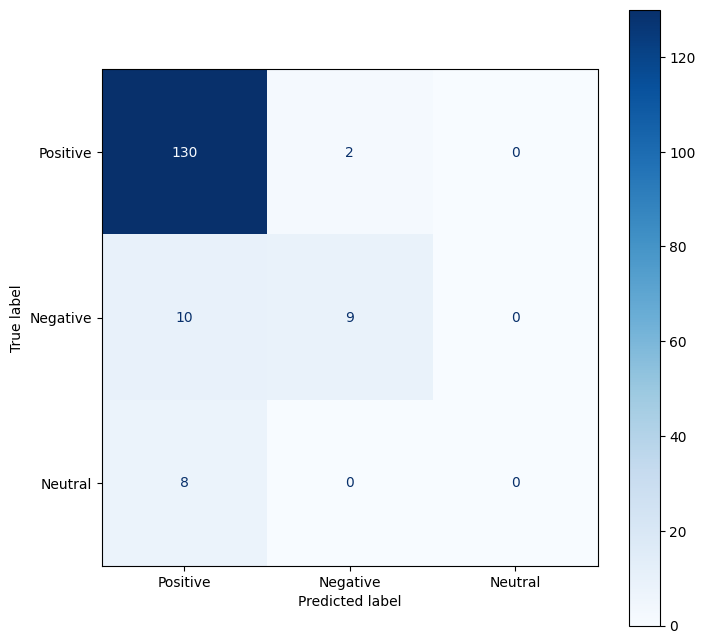

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
                  df_test['positions_vac'],
                  test_preds,
                  labels=[0,1,2],
                  cmap=plt.cm.Blues,
                  display_labels=['Positive','Negative', 'Neutral'],
                  values_format='',
)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)

### Avaliação no banco de teste (Melhor Fold)

---



In [ ]:
# Resumo do processo de treino

pd.set_option('display.precision', 2)

# Criando um dataframe com nossas estatísticas de treino.

df_stats = pd.DataFrame(data = training_stats)

# Usando cada 'epoch' como índice

df_stats = df_stats.set_index('fold')

# Pegar o fold com maior valor de f1-macro

bestsplit = df_stats['macro_f1_score'].idxmax()

df_stats['macro_f1_score'].idxmax()

0

In [ ]:
# Take the argmax. This returns the column index of the max value in each row.

# Sum the predictions of all fold models
for i, item in enumerate(model_preds_list):

    if i == bestsplit:
        preds_bestsplit = item


bestsplit_preds = np.argmax(preds_bestsplit, axis=1)

In [ ]:
accuracy_score(df_test['positions_vac'], bestsplit_preds)

0.8805031446540881

In [ ]:
print(classification_report(df_test['positions_vac'], bestsplit_preds, labels = [0,1,2]))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94       132
           1       0.82      0.47      0.60        19
           2       0.50      0.12      0.20         8

    accuracy                           0.88       159
   macro avg       0.74      0.53      0.58       159
weighted avg       0.86      0.88      0.86       159



In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy


confusion_matrix = metrics.confusion_matrix(df_test['positions_vac'], bestsplit_preds)

confusion_matrix

array([[130,   2,   0],
       [  9,   9,   1],
       [  7,   0,   1]])

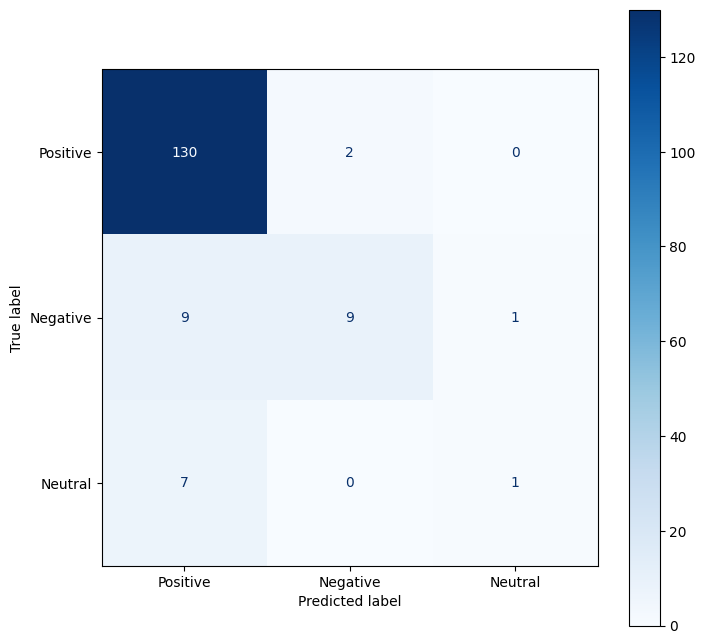

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
                  df_test['positions_vac'],
                  bestsplit_preds,
                  labels=[0,1,2],
                  cmap=plt.cm.Blues,
                  display_labels=['Positive','Negative', 'Neutral'],
                  values_format='',
)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)

### Resumo do processo de Treino

In [ ]:
# Resumo do processo de treino

pd.set_option('display.precision', 2)

# Criando um dataframe com nossas estatísticas de treino.

df_stats = pd.DataFrame(data = training_stats)

# Usando cada 'fold' como índice

df_stats = df_stats.set_index('epoch')

# mostrar a tabela.

df_stats


,Training Loss,Valid. Loss,Valid. Accur.,f1_score_micro,macro_f1_score,weighted_f1_score,classification_report,fold
epoch,,,,,,,,
1,0.59,0.50,0.83,0.83,0.34,0.91,precision recall f1-score sup...,0
2,0.43,0.39,0.88,0.88,0.55,0.91,precision recall f1-score sup...,0
3,0.28,0.41,0.87,0.87,0.56,0.89,precision recall f1-score sup...,0
4,0.18,0.41,0.89,0.89,0.61,0.91,precision recall f1-score sup...,0
5,0.11,0.46,0.89,0.89,0.63,0.90,precision recall f1-score sup...,0
1,0.58,0.51,0.83,0.83,0.37,0.90,precision recall f1-score sup...,1
2,0.43,0.50,0.84,0.84,0.47,0.90,precision recall f1-score sup...,1
3,0.33,0.40,0.87,0.87,0.59,0.90,precision recall f1-score sup...,1
4,0.23,0.44,0.87,0.87,0.59,0.90,precision recall f1-score sup...,1


In [ ]:
df_stats[df_stats['fold'] == 0].mean()

<ipython-input-45-199d0543ff22>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_stats[df_stats['fold'] == 0].mean()


Training Loss        0.32
Valid. Loss          0.43
Valid. Accur.        0.87
f1_score_micro       0.87
macro_f1_score       0.54
weighted_f1_score    0.91
fold                 0.00
dtype: float64

In [ ]:

df_stats2 = pd.DataFrame(data = training_stats)
df_stats2 = df_stats2.set_index('fold')


df_stats2[df_stats2['epoch'] == 5]


,epoch,Training Loss,Valid. Loss,Valid. Accur.,f1_score_micro,macro_f1_score,weighted_f1_score,classification_report
fold,,,,,,,,
0,5,0.11,0.46,0.89,0.89,0.63,0.90,precision recall f1-score sup...
1,5,0.18,0.45,0.88,0.88,0.62,0.91,precision recall f1-score sup...
2,5,0.20,0.49,0.87,0.87,0.57,0.90,precision recall f1-score sup...
3,5,0.19,0.56,0.86,0.86,0.50,0.89,precision recall f1-score sup...
4,5,0.33,0.39,0.89,0.89,0.59,0.92,precision recall f1-score sup...


In [ ]:
df_stats2[df_stats2['epoch'] == 5].mean()

<ipython-input-47-7c5ffd46eb4c>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_stats2[df_stats2['epoch'] == 5].mean()


epoch                5.00
Training Loss        0.20
Valid. Loss          0.47
Valid. Accur.        0.88
f1_score_micro       0.88
macro_f1_score       0.58
weighted_f1_score    0.90
dtype: float64

In [ ]:
df_stats.classification_report.iloc[10] # Epoch 3, fold 0

,precision,recall,f1-score,support
0,0.83,1.00,0.91,237.00
1,0.00,0.00,0.00,34.00
2,0.00,0.00,0.00,15.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.28,0.33,0.30,286.00
weighted avg,0.69,0.83,0.75,286.00


In [ ]:
df_fold0 = df_stats[df_stats['fold'] == 0]

df_fold0

,Training Loss,Valid. Loss,Valid. Accur.,f1_score_micro,macro_f1_score,weighted_f1_score,classification_report,fold
epoch,,,,,,,,
1,0.59,0.50,0.83,0.83,0.34,0.91,precision recall f1-score sup...,0
2,0.43,0.39,0.88,0.88,0.55,0.91,precision recall f1-score sup...,0
3,0.28,0.41,0.87,0.87,0.56,0.89,precision recall f1-score sup...,0
4,0.18,0.41,0.89,0.89,0.61,0.91,precision recall f1-score sup...,0
5,0.11,0.46,0.89,0.89,0.63,0.90,precision recall f1-score sup...,0


In [ ]:
df_fold0.classification_report[1] # Isso pega a 1° Epoch

,precision,recall,f1-score,support
0,0.83,1.00,0.91,238.00
1,0.00,0.00,0.00,34.00
2,0.00,0.00,0.00,14.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.28,0.33,0.30,286.00
weighted avg,0.69,0.83,0.76,286.00


In [ ]:
df_fold0.classification_report[1].iloc[[0]] # Métricas da primeira classe na primeira epoch

,precision,recall,f1-score,support
0,0.83,1.0,0.91,238.0


In [ ]:
df_fold0.classification_report[1].iloc[[0]].iloc[:,0] # Primeira métrica (precision) da primeira classe na primeira epoch

0    0.83
Name: precision, dtype: float64

In [ ]:

class0 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class0.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[0]].iloc[:,3])
                            })

    j += 1



class0 = pd.DataFrame(data = class0)

class0




,epoch,fold,precision,recall,f1-score,support
0,1,0,0.83,1.00,0.91,238
1,2,0,0.89,0.98,0.93,238
2,3,0,0.90,0.96,0.93,238
3,4,0,0.92,0.97,0.94,238
4,5,0,0.91,0.96,0.94,238
5,1,1,0.83,1.00,0.91,237
6,2,1,0.85,1.00,0.91,237
7,3,1,0.88,0.99,0.93,237
8,4,1,0.88,0.99,0.93,237
9,5,1,0.89,0.99,0.94,237


In [ ]:
class0.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.89,0.97,0.93,238.0
1,3.0,0.87,0.99,0.92,237.0
2,3.0,0.87,0.97,0.92,237.0
3,3.0,0.87,0.98,0.92,237.0
4,3.0,0.87,1.00,0.93,238.0


#### Classe 0 Epoch 5 para todos os folds

In [ ]:
class0[class0['epoch'] == 5]

,epoch,fold,precision,recall,f1-score,support
4,5,0,0.91,0.96,0.94,238
9,5,1,0.89,0.99,0.94,237
14,5,2,0.89,0.96,0.92,237
19,5,3,0.88,0.97,0.93,237
24,5,4,0.88,1.00,0.93,238


In [ ]:
class0[class0['epoch'] == 5].mean()

epoch          5.00
fold           2.00
precision      0.89
recall         0.98
f1-score       0.93
support      237.40
dtype: float64

In [ ]:
class1 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class1.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[1]].iloc[:,3])
                            })

    j += 1



class1 = pd.DataFrame(data = class1)

class1

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.00,0.00,0.00,34
1,2,0,0.83,0.56,0.67,34
2,3,0,0.69,0.65,0.67,34
3,4,0,0.71,0.74,0.72,34
4,5,0,0.75,0.71,0.73,34
5,1,1,0.00,0.00,0.00,34
6,2,1,0.71,0.15,0.24,34
7,3,1,0.76,0.47,0.58,34
8,4,1,0.75,0.44,0.56,34
9,5,1,0.84,0.47,0.60,34


In [ ]:
class1.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.60,0.53,0.56,34.0
1,3.0,0.61,0.31,0.40,34.0
2,3.0,0.52,0.42,0.47,34.0
3,3.0,0.57,0.38,0.41,34.0
4,3.0,0.74,0.36,0.49,33.0


In [ ]:
class1[class1['epoch'] == 5]

,epoch,fold,precision,recall,f1-score,support
4,5,0,0.75,0.71,0.73,34
9,5,1,0.84,0.47,0.60,34
14,5,2,0.69,0.59,0.63,34
19,5,3,0.67,0.47,0.55,34
24,5,4,0.94,0.48,0.64,33


In [ ]:
class1[class1['epoch'] == 5].mean()

epoch         5.00
fold          2.00
precision     0.78
recall        0.54
f1-score      0.63
support      33.80
dtype: float64

In [ ]:
class2 = []
i = 0
j = 0

for i in range(0,5):
  i += 1
  for j in range(0,5):
    metrics_0 = class2.append({'epoch': j + 1,
                            'fold': i - 1,
                            'precision': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,0]),
                            'recall': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,1]),
                            'f1-score': float(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,2]),
                            'support': int(df_stats[df_stats['fold'] == i - 1].classification_report[j+1].iloc[[2]].iloc[:,3])
                            })

    j += 1



class2 = pd.DataFrame(data = class2)

class2

,epoch,fold,precision,recall,f1-score,support
0,1,0,0.00,0.00,0.00,14
1,2,0,0.00,0.00,0.00,14
2,3,0,0.00,0.00,0.00,14
3,4,0,0.00,0.00,0.00,14
4,5,0,0.33,0.07,0.12,14
5,1,1,0.00,0.00,0.00,15
6,2,1,0.00,0.00,0.00,15
7,3,1,0.00,0.00,0.00,15
8,4,1,1.00,0.07,0.12,15
9,5,1,0.33,0.07,0.11,15


In [ ]:
class2.groupby(['fold']).mean()

,epoch,precision,recall,f1-score,support
fold,,,,,
0,3.0,0.07,0.01,0.02,14.0
1,3.0,0.27,0.03,0.05,15.0
2,3.0,0.20,0.01,0.03,15.0
3,3.0,0.00,0.00,0.00,15.0
4,3.0,0.00,0.00,0.00,15.0


In [ ]:
class2[class2['epoch'] == 5]

,epoch,fold,precision,recall,f1-score,support
4,5,0,0.33,0.07,0.12,14
9,5,1,0.33,0.07,0.11,15
14,5,2,1.00,0.07,0.12,15
19,5,3,0.00,0.00,0.00,15
24,5,4,0.00,0.00,0.00,15


In [ ]:
class2[class2['epoch'] == 5].mean()

epoch         5.00
fold          2.00
precision     0.33
recall        0.04
f1-score      0.07
support      14.80
dtype: float64

<ipython-input-65-553fcee8258e>:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treino_loss = df_stats.groupby(['epoch']).mean()['Training Loss']
<ipython-input-65-553fcee8258e>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  valida_loss = df_stats.groupby(['epoch']).mean()['Valid. Loss']


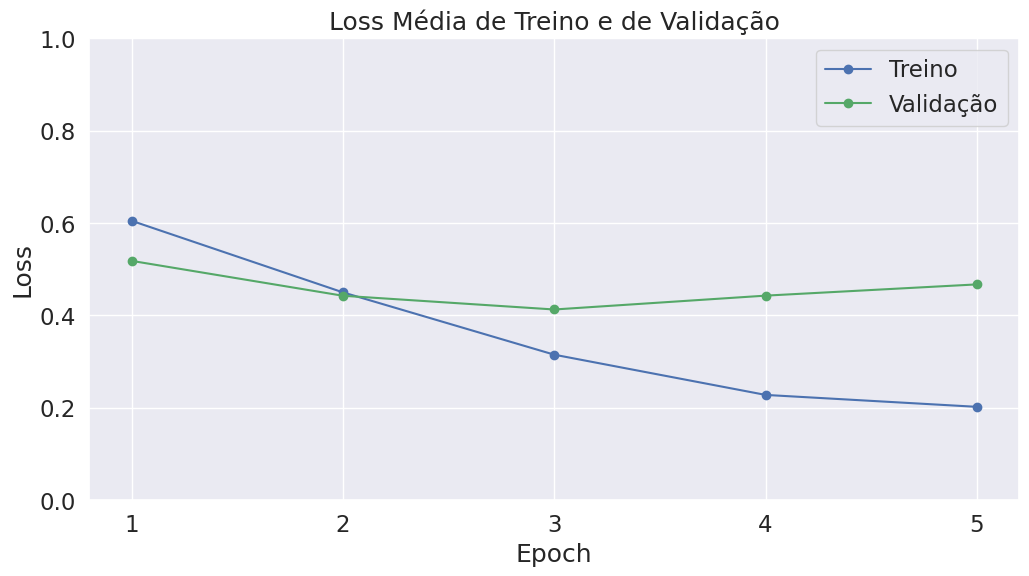

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Plot styling

sns.set(style = "darkgrid")

# Aumenttndo o tamanho do plot e da fonte

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Curva de aprendizado

treino_loss = df_stats.groupby(['epoch']).mean()['Training Loss']
valida_loss = df_stats.groupby(['epoch']).mean()['Valid. Loss']


treino_valid = pd.merge(treino_loss, valida_loss, right_index = True,
               left_index = True)


plt.plot(treino_valid['Training Loss'], 'b-o', label = "Treino")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validação")

# Labels

plt.title("Loss Média de Treino e de Validação")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

plt.show()




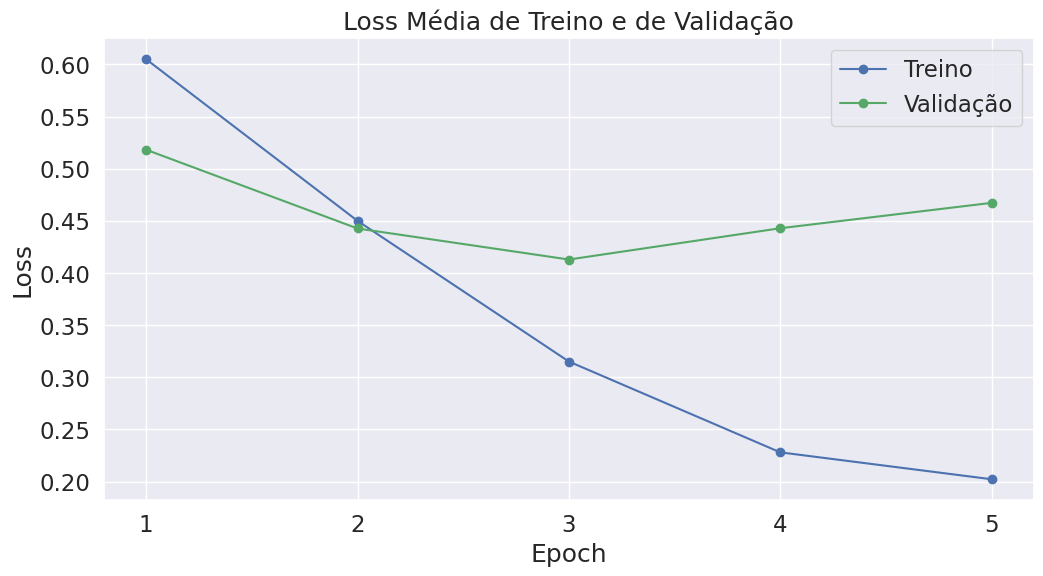

In [ ]:
plt.plot(treino_valid['Training Loss'], 'b-o', label = "Treino")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validação")

# Labels

plt.title("Loss Média de Treino e de Validação")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])

plt.show()

## Gráficos Classe Positiva (0)

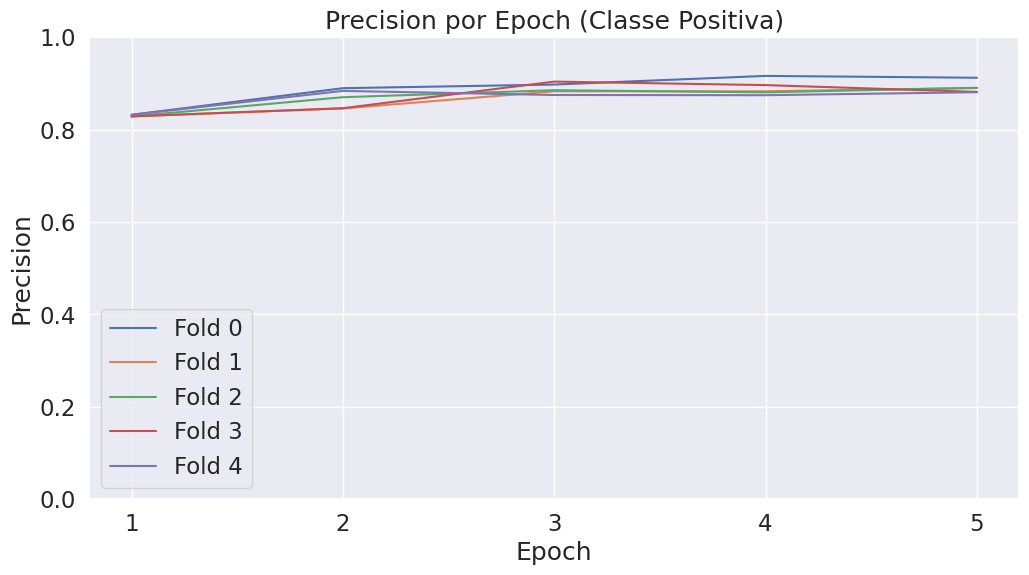

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['precision'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')

plt.title("Precision por Epoch (Classe Positiva)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

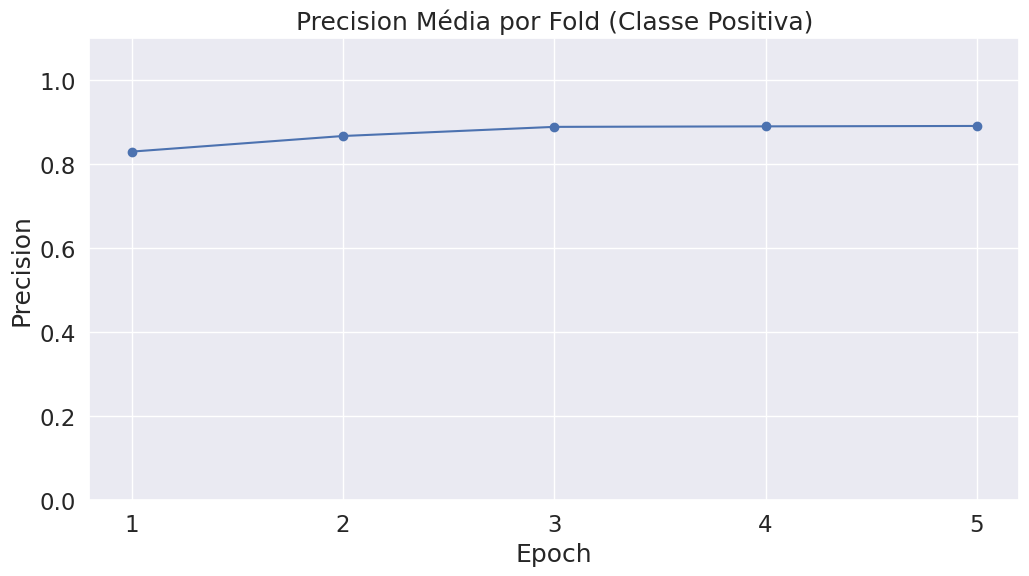

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('epoch').mean()

plt.plot(grouped['precision'], 'b-o')

# Labels

plt.title("Precision Média por Fold (Classe Positiva)")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()


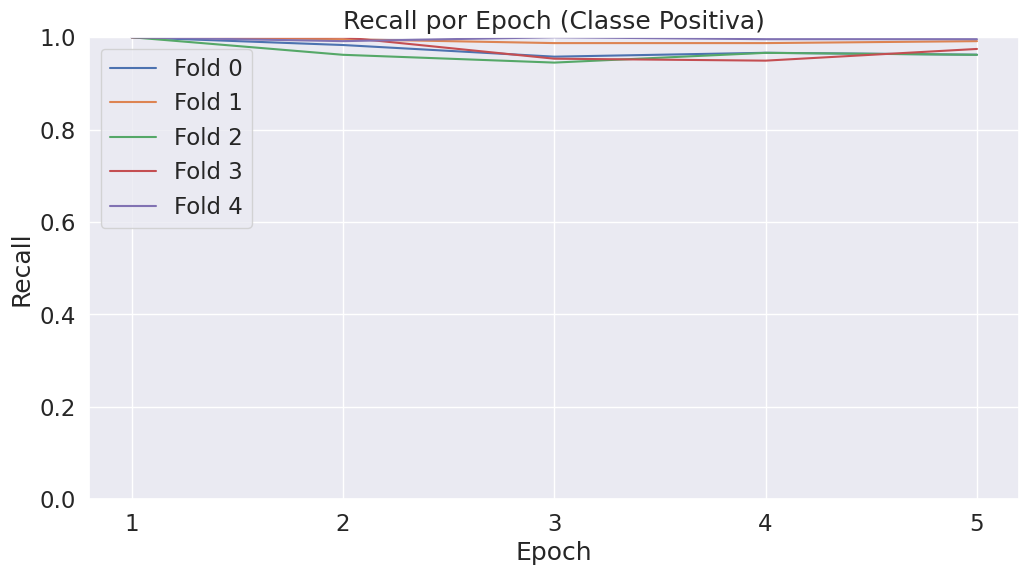

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['recall'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')

plt.title("Recall por Epoch (Classe Positiva)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

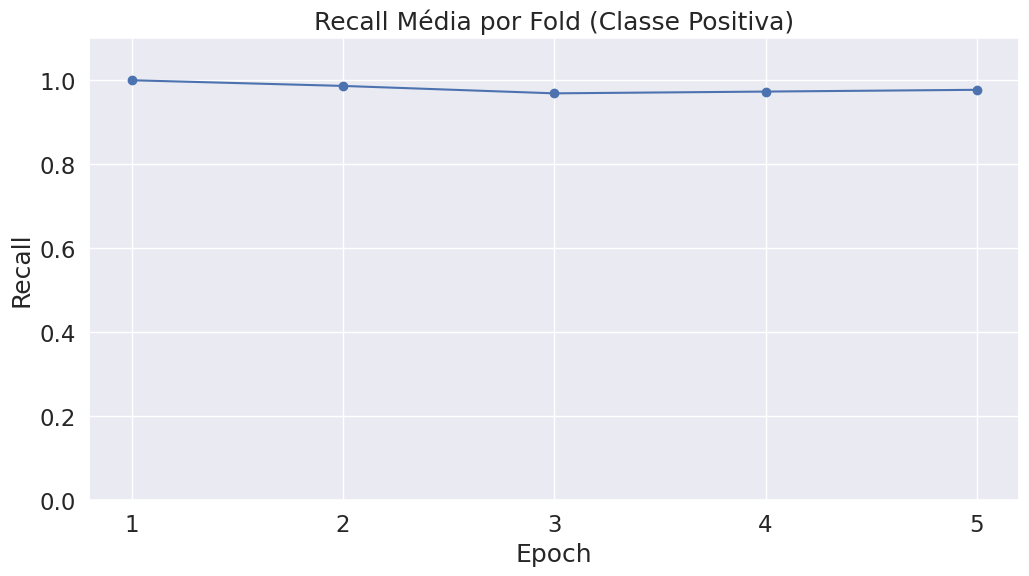

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('epoch').mean()

plt.plot(grouped['recall'], 'b-o')

# Labels

plt.title("Recall Média por Fold (Classe Positiva)")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

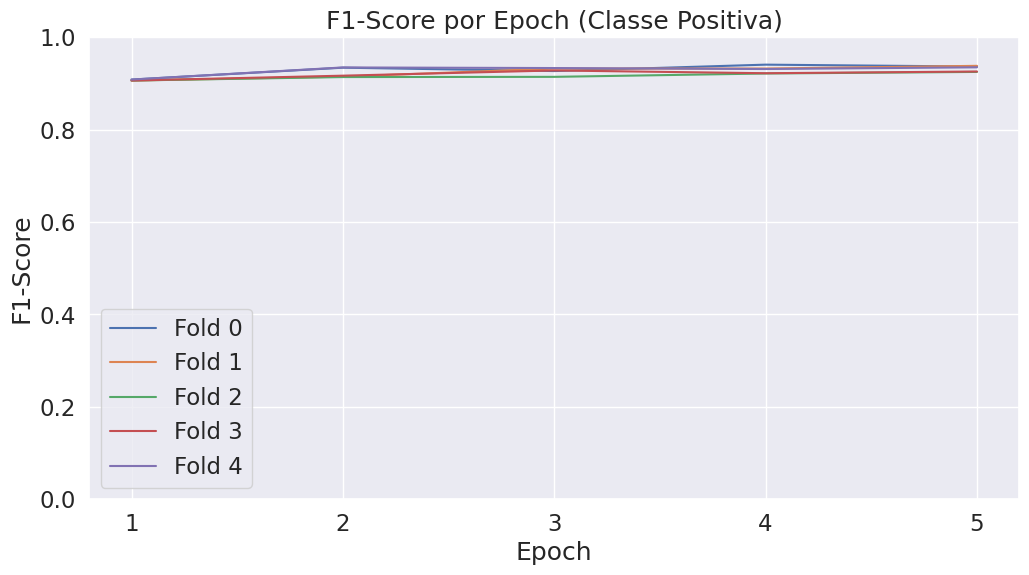

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['f1-score'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('F1-Score')

plt.title("F1-Score por Epoch (Classe Positiva)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

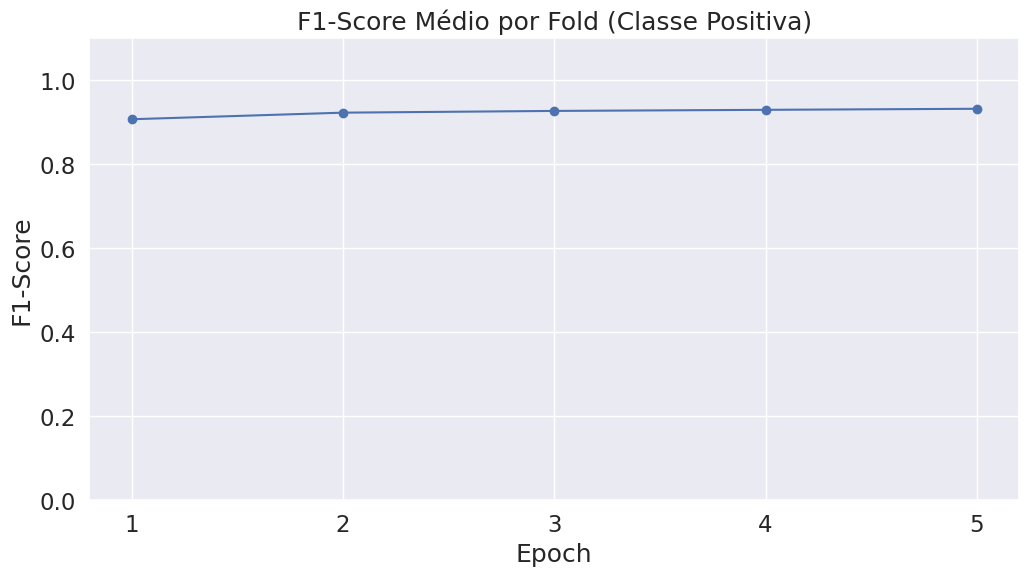

In [ ]:
# Group the dataframe by fold number
grouped = class0.groupby('epoch').mean()

plt.plot(grouped['f1-score'], 'b-o')

# Labels

plt.title("F1-Score Médio por Fold (Classe Positiva)")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

## Gráficos Classe Negativa

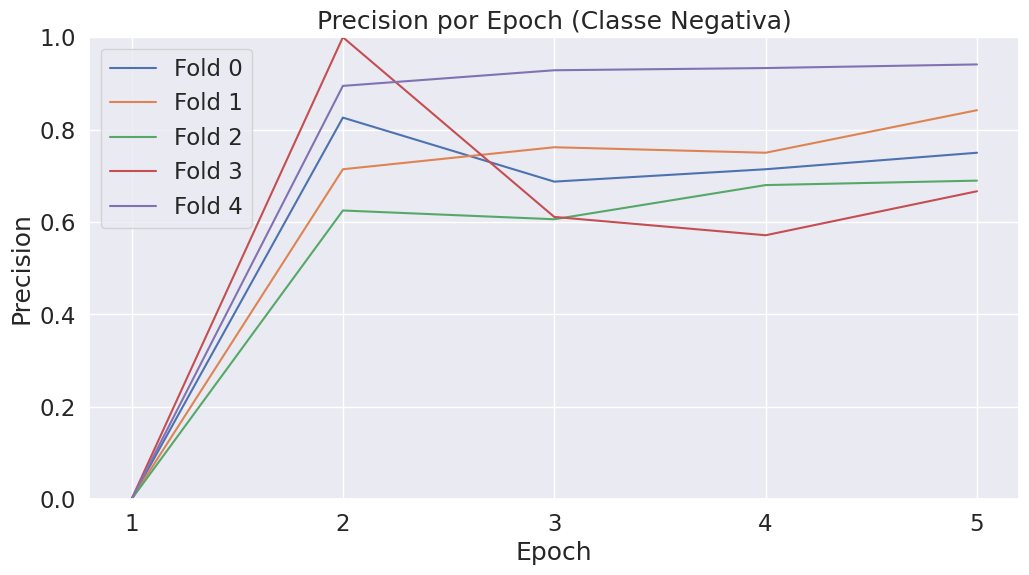

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['precision'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')

plt.title("Precision por Epoch (Classe Negativa)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

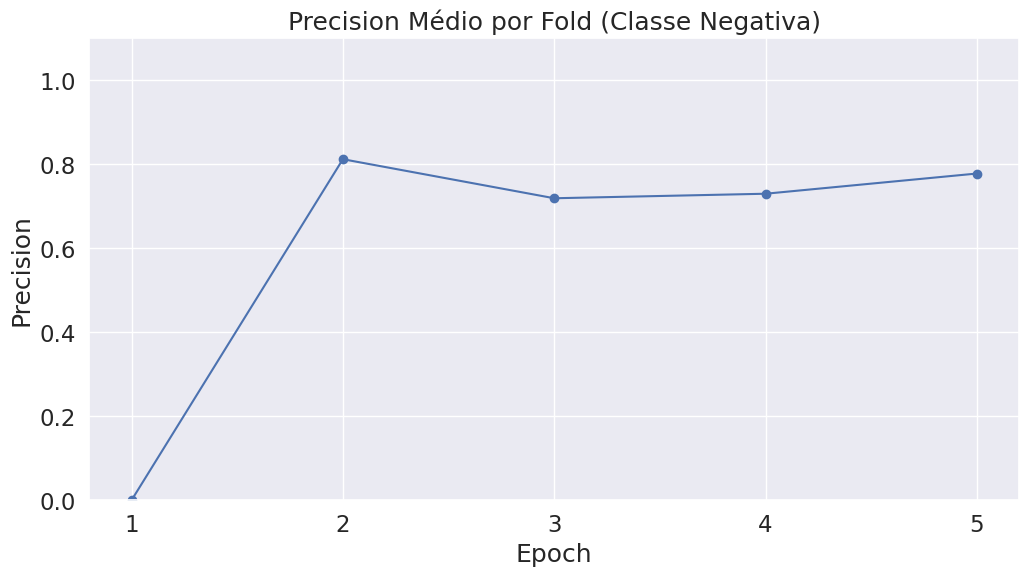

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('epoch').mean()

plt.plot(grouped['precision'], 'b-o')

# Labels

plt.title("Precision Médio por Fold (Classe Negativa)")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

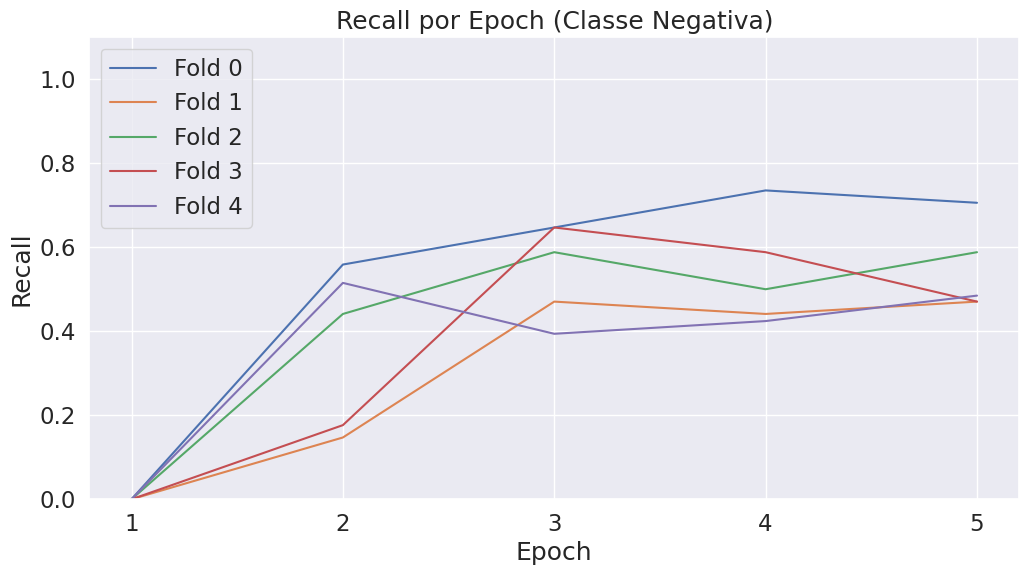

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['recall'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')

plt.title("Recall por Epoch (Classe Negativa)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

# Show the plot
plt.show()

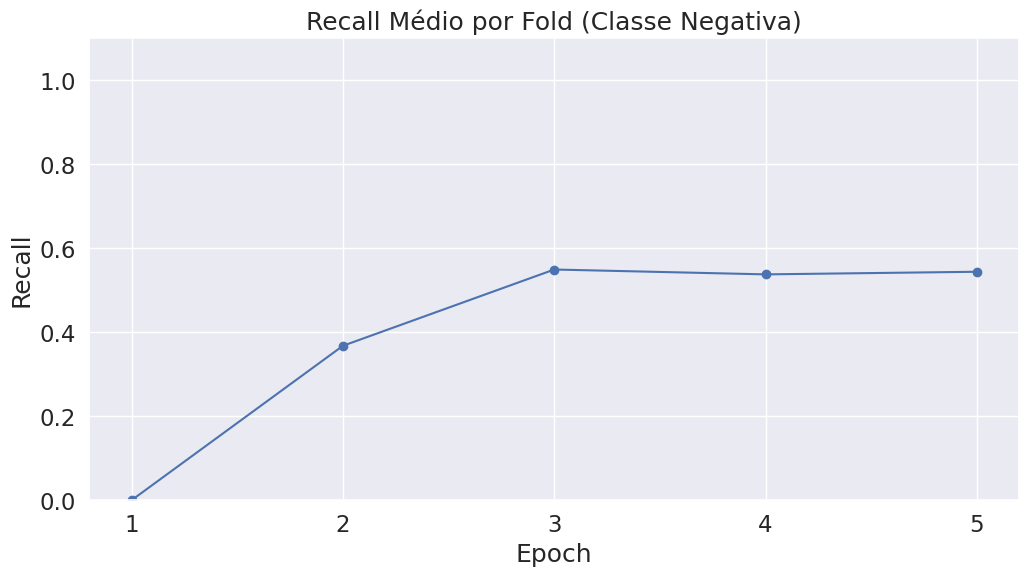

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('epoch').mean()

plt.plot(grouped['recall'], 'b-o')

# Labels

plt.title("Recall Médio por Fold (Classe Negativa)")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

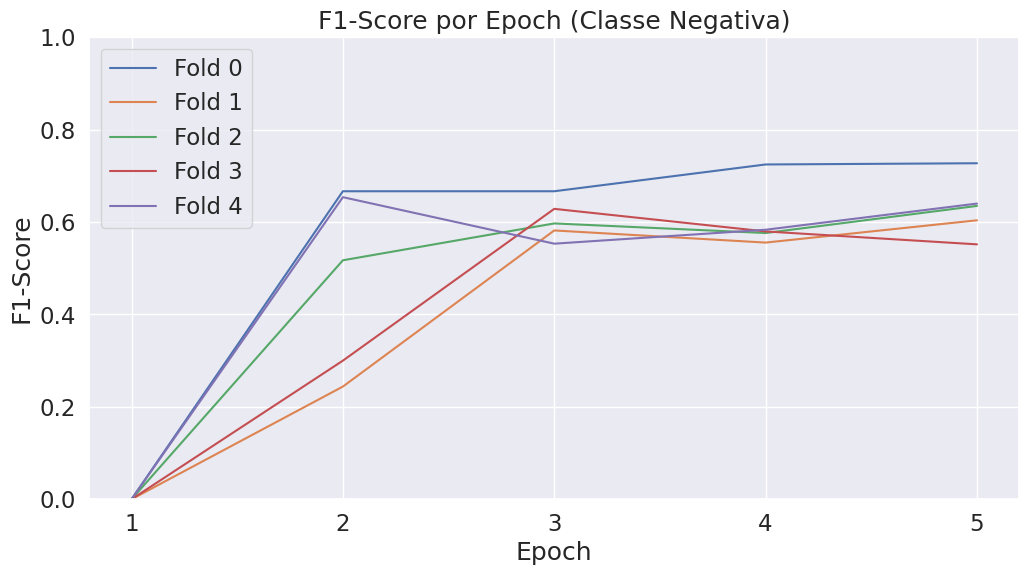

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['f1-score'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('F1-Score')

plt.title("F1-Score por Epoch (Classe Negativa)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

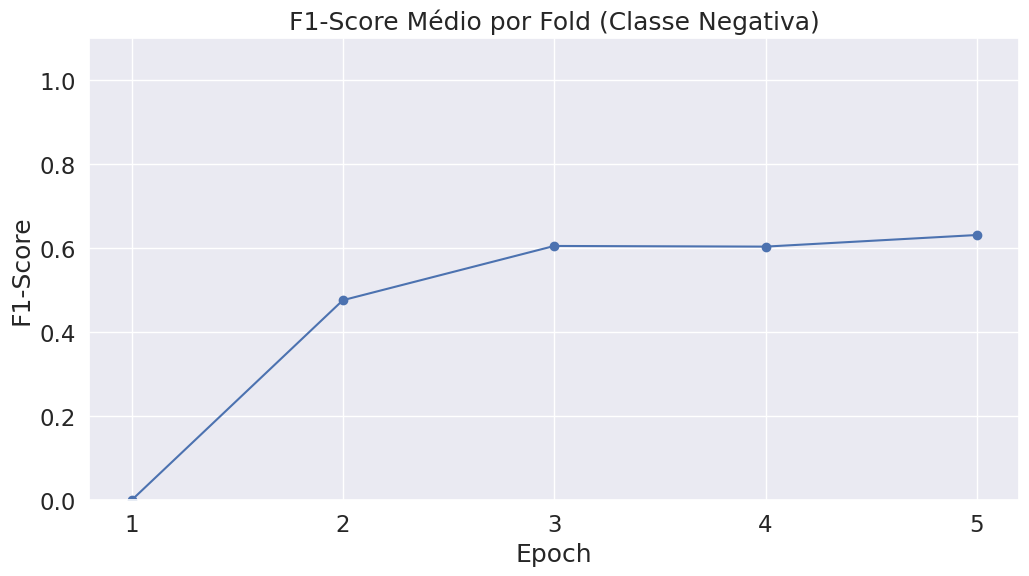

In [ ]:
# Group the dataframe by fold number
grouped = class1.groupby('epoch').mean()

plt.plot(grouped['f1-score'], 'b-o')

# Labels

plt.title("F1-Score Médio por Fold (Classe Negativa)")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))

plt.show()

## Classe Neutra

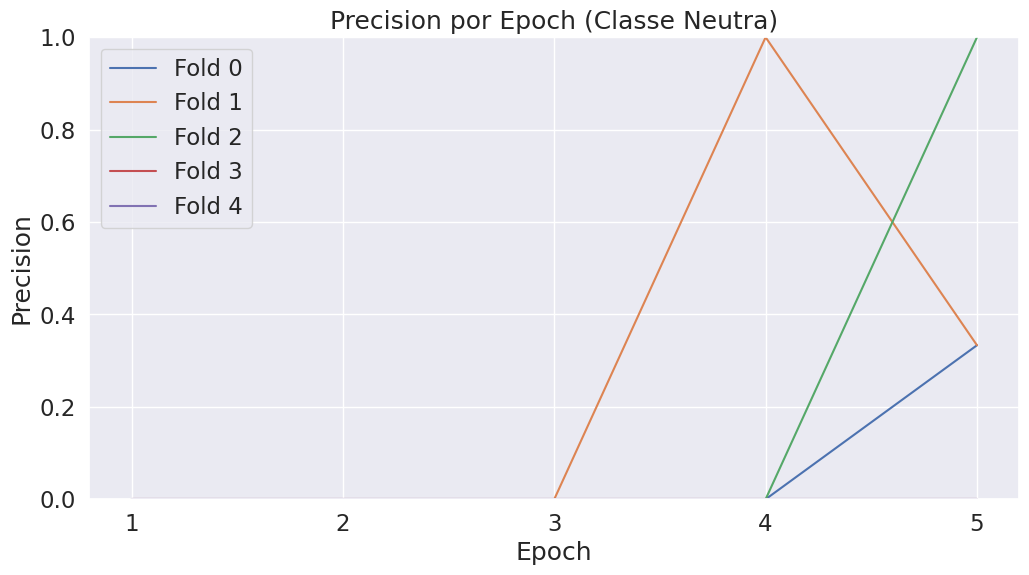

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['precision'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')

plt.title("Precision por Epoch (Classe Neutra)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

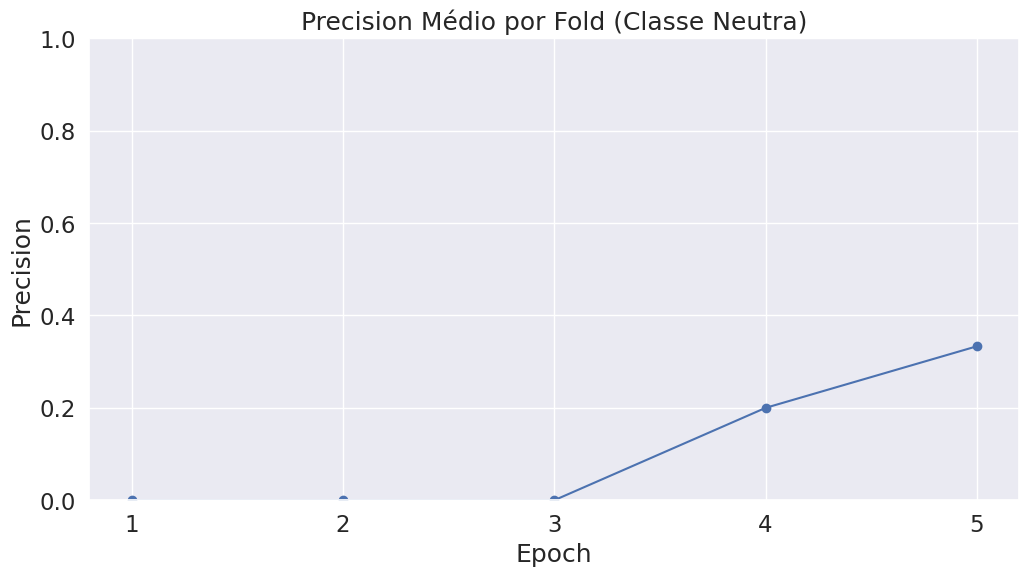

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('epoch').mean()

plt.plot(grouped['precision'], 'b-o')

# Labels

plt.title("Precision Médio por Fold (Classe Neutra)")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

plt.show()

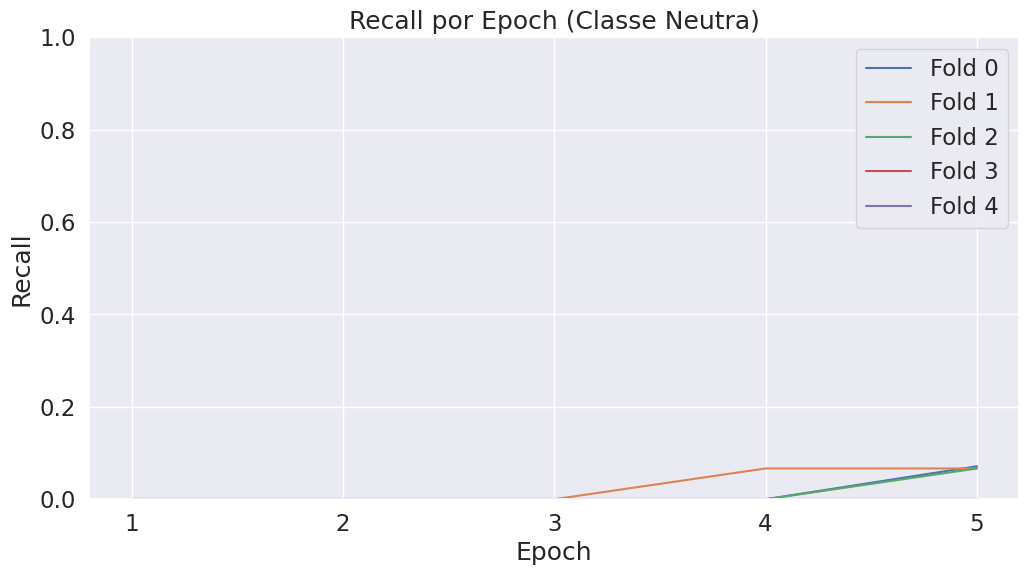

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['recall'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')

plt.title("Recall por Epoch (Classe Neutra)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

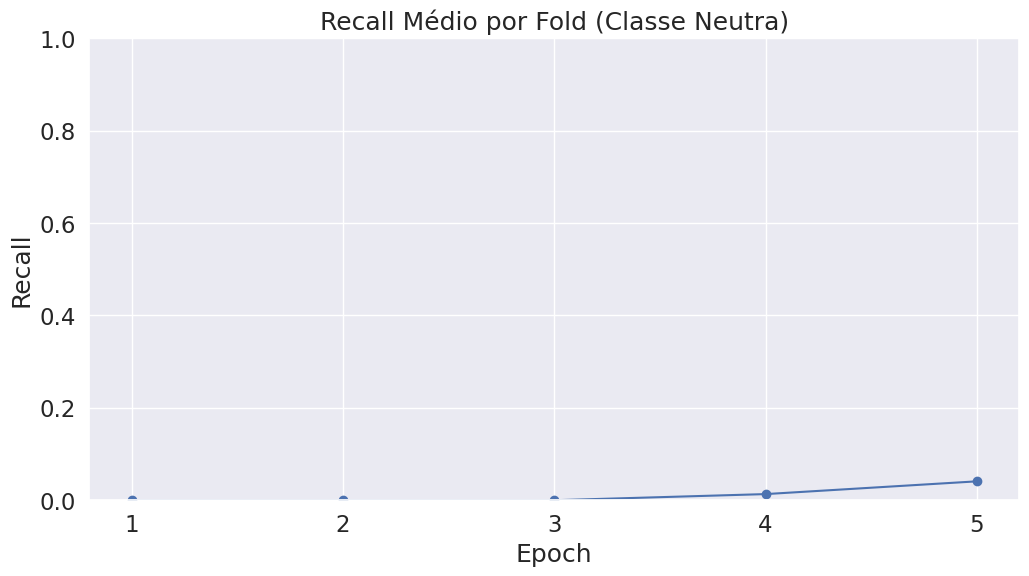

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('epoch').mean()

plt.plot(grouped['recall'], 'b-o')

# Labels

plt.title("Recall Médio por Fold (Classe Neutra)")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

plt.show()

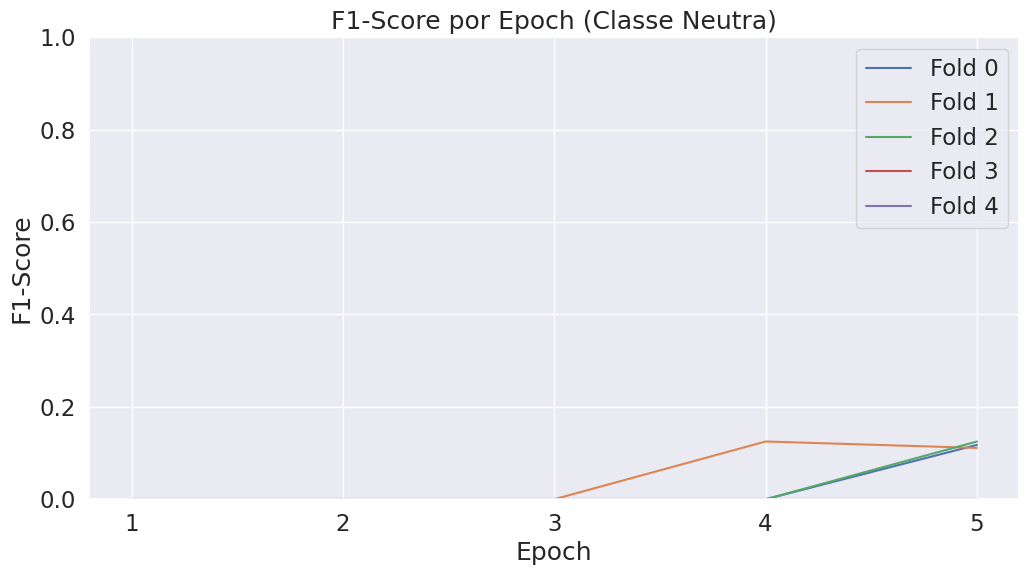

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('fold')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot a line for each fold
for name, group in grouped:
    ax.plot(group['epoch'], group['f1-score'], label=f"Fold {name}")

# Add a legend to the plot
ax.legend()

# Add labels to the x and y axis
ax.set_xlabel('Epoch')
ax.set_ylabel('F1-Score')

plt.title("F1-Score por Epoch (Classe Neutra)")

plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

# Show the plot
plt.show()

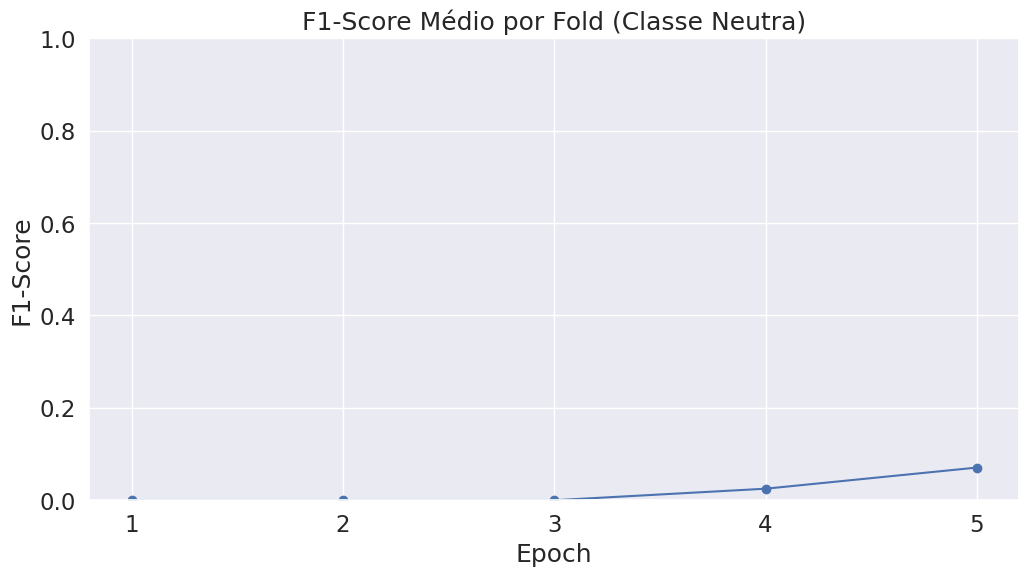

In [ ]:
# Group the dataframe by fold number
grouped = class2.groupby('epoch').mean()

plt.plot(grouped['f1-score'], 'b-o')

# Labels

plt.title("F1-Score Médio por Fold (Classe Neutra)")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))

plt.show()

### Criando Figuras para o Artigo




Average Precision for Each Class

In [ ]:
grouped0 = class0.groupby('epoch').mean()
grouped1 = class1.groupby('epoch').mean()
grouped2 = class2.groupby('epoch').mean()

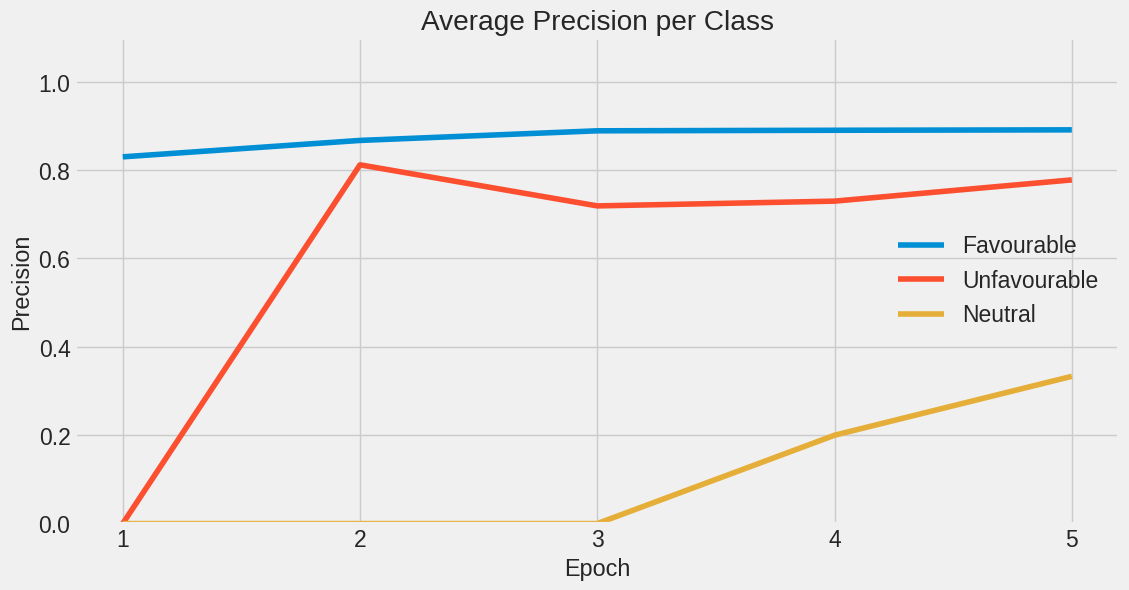

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['precision'], label = "Favourable")
plt.plot(grouped1['precision'], label = "Unfavourable")
plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.title("Average Precision per Class")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.show()

plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgprecisionclass.eps', format='eps', transparent = True, bbox_inches='tight')

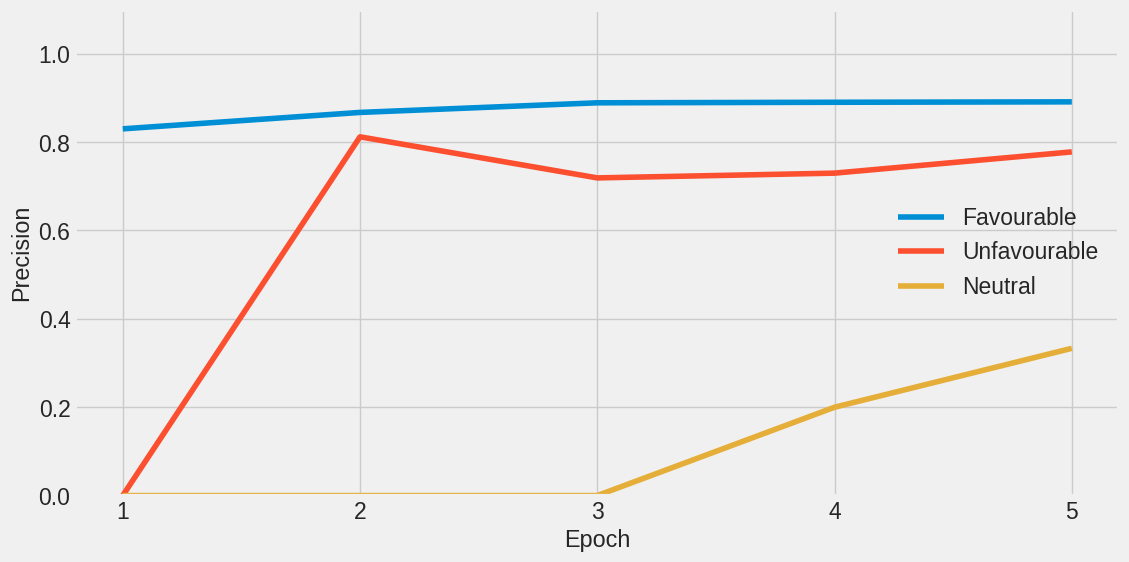

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['precision'], label = "Favourable")
plt.plot(grouped1['precision'], label = "Unfavourable")
plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgprecisionclassnoleg.eps', format='eps', transparent = True, bbox_inches='tight')

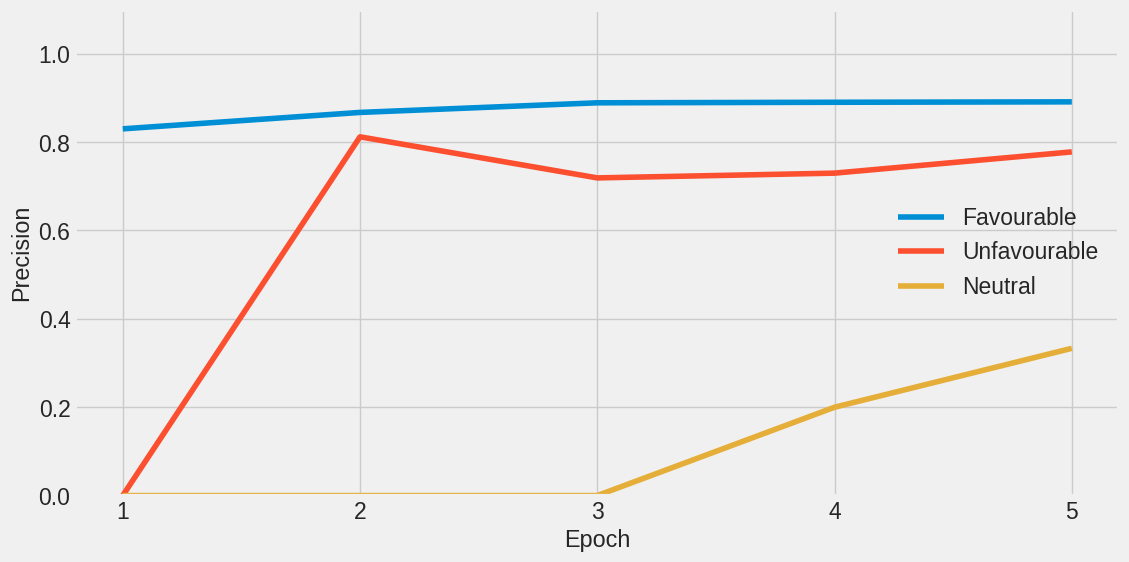

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['precision'], label = "Favourable")
plt.plot(grouped1['precision'], label = "Unfavourable")
plt.plot(grouped2['precision'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()

plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgprecisionclassnoleg.png', format='png', transparent = True, bbox_inches='tight')

Recall

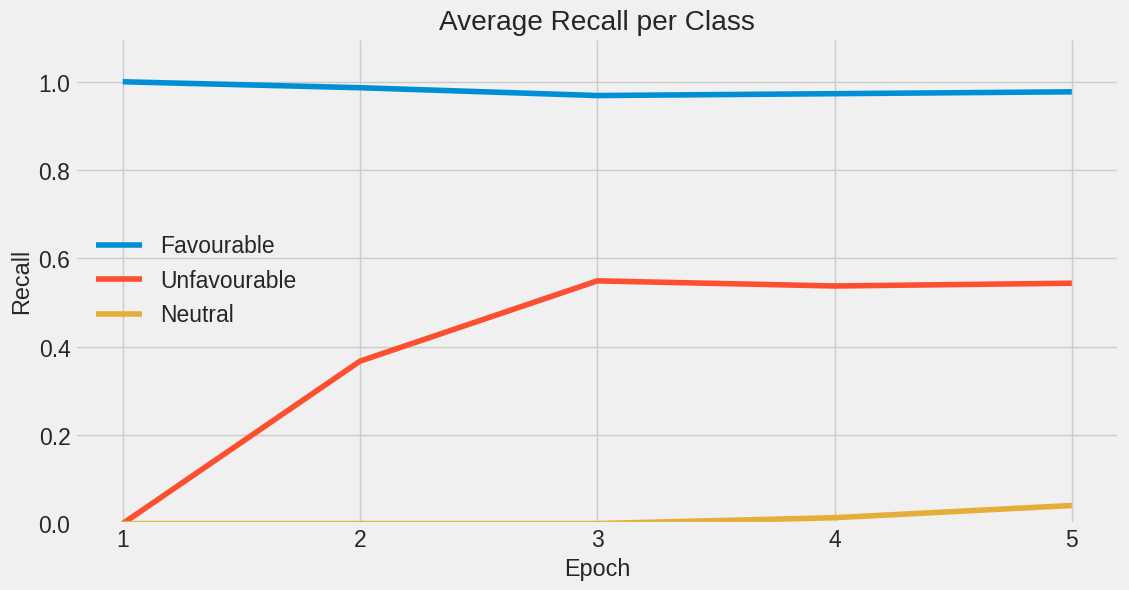

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['recall'], label = "Favourable")
plt.plot(grouped1['recall'], label = "Unfavourable")
plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.title("Average Recall per Class")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgrecallclass.eps', format='eps', transparent = True, bbox_inches='tight')

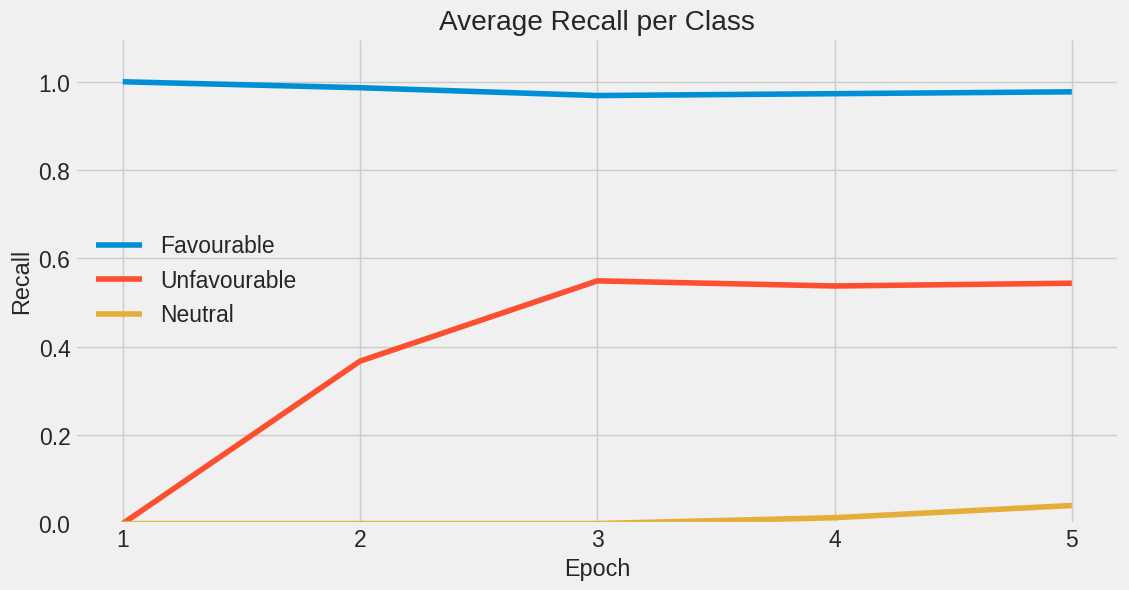

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['recall'], label = "Favourable")
plt.plot(grouped1['recall'], label = "Unfavourable")
plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.title("Average Recall per Class")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgrecallclass.png', format='png', transparent = True, bbox_inches='tight')

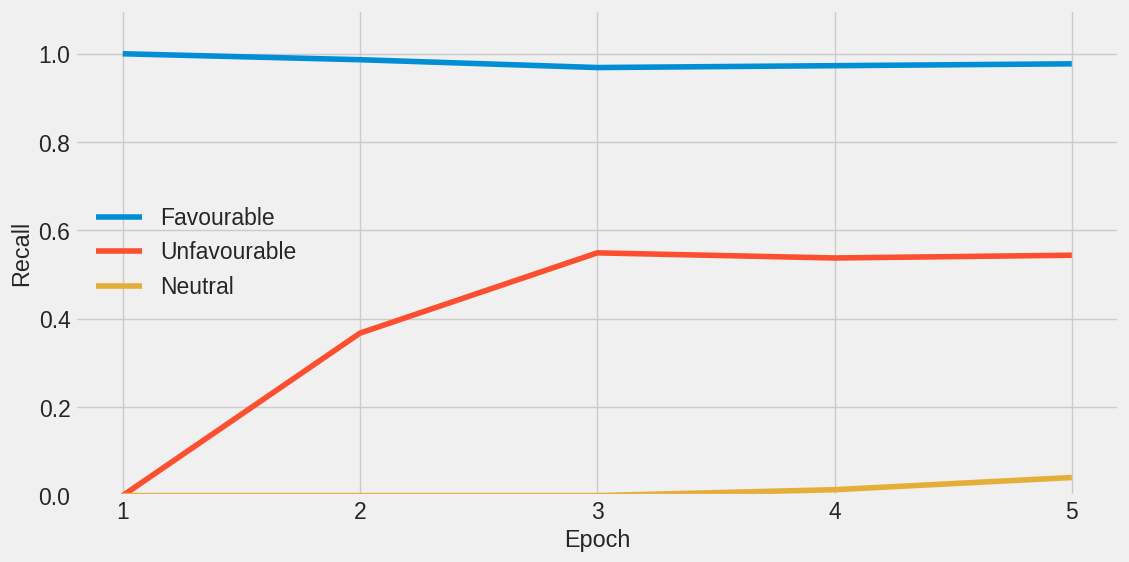

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['recall'], label = "Favourable")
plt.plot(grouped1['recall'], label = "Unfavourable")
plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgrecallclassnoleg.eps', format='eps', transparent = True, bbox_inches='tight')

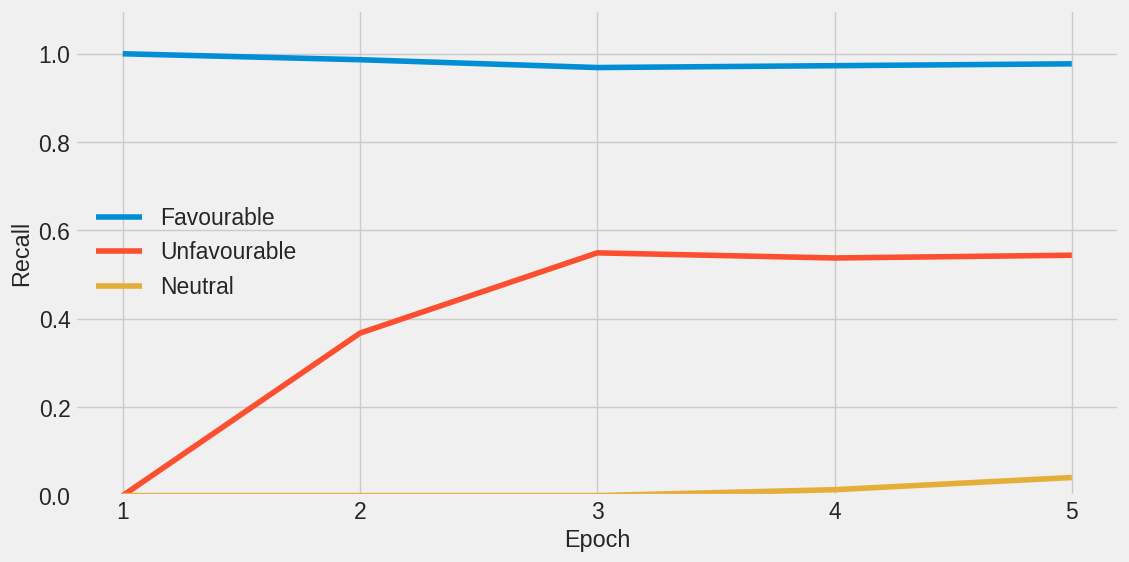

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['recall'], label = "Favourable")
plt.plot(grouped1['recall'], label = "Unfavourable")
plt.plot(grouped2['recall'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()



plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgrecallclassnoleg.png', format='png', transparent = True, bbox_inches='tight')

F1-Score

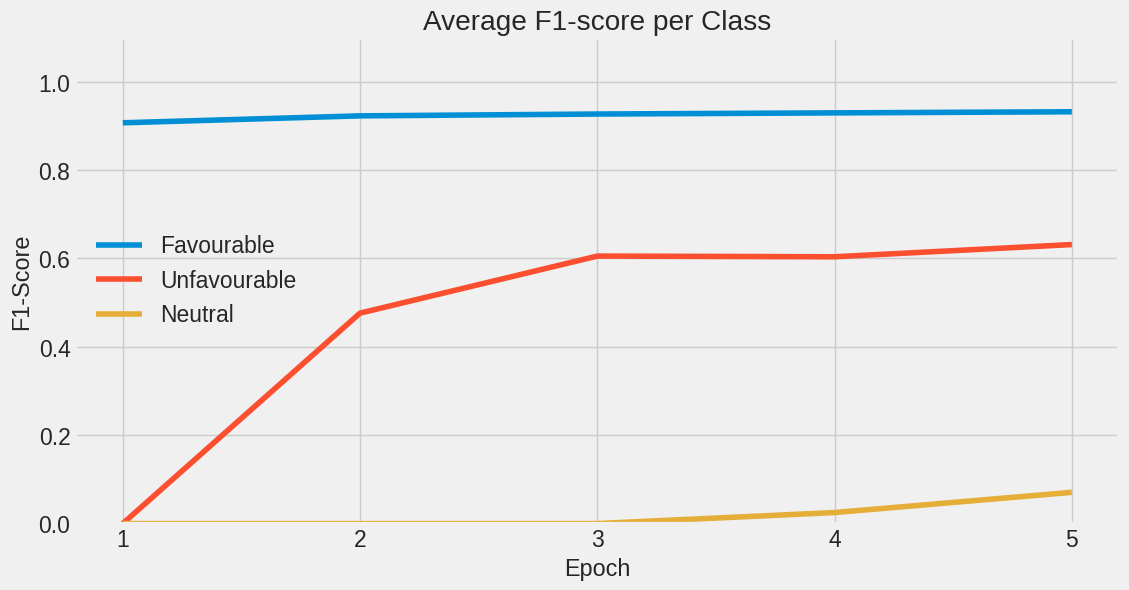

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['f1-score'], label = "Favourable")
plt.plot(grouped1['f1-score'], label = "Unfavourable")
plt.plot(grouped2['f1-score'], label = "Neutral")


# Labels

plt.title("Average F1-score per Class")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()


plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgf1class.eps', format='eps', transparent = True, bbox_inches='tight')

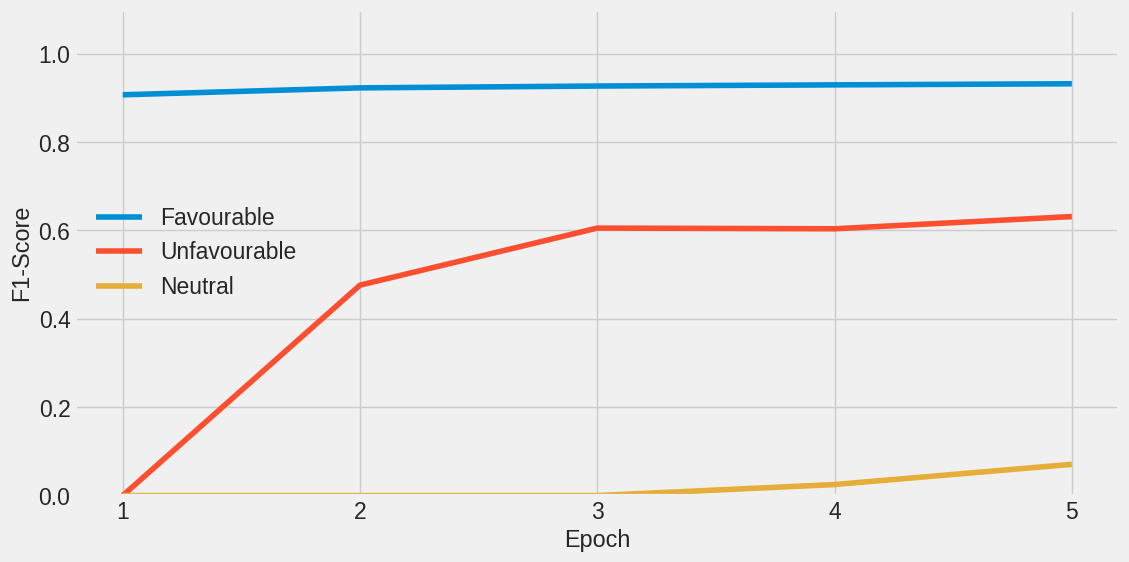

In [ ]:
# Set the style to a minimalist theme
plt.style.use('fivethirtyeight')

plt.plot(grouped0['f1-score'], label = "Favourable")
plt.plot(grouped1['f1-score'], label = "Unfavourable")
plt.plot(grouped2['f1-score'], label = "Neutral")


# Labels

plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1.1))
plt.legend()



plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgf1classnoleg.eps', format='eps', transparent = True, bbox_inches='tight')

Loss

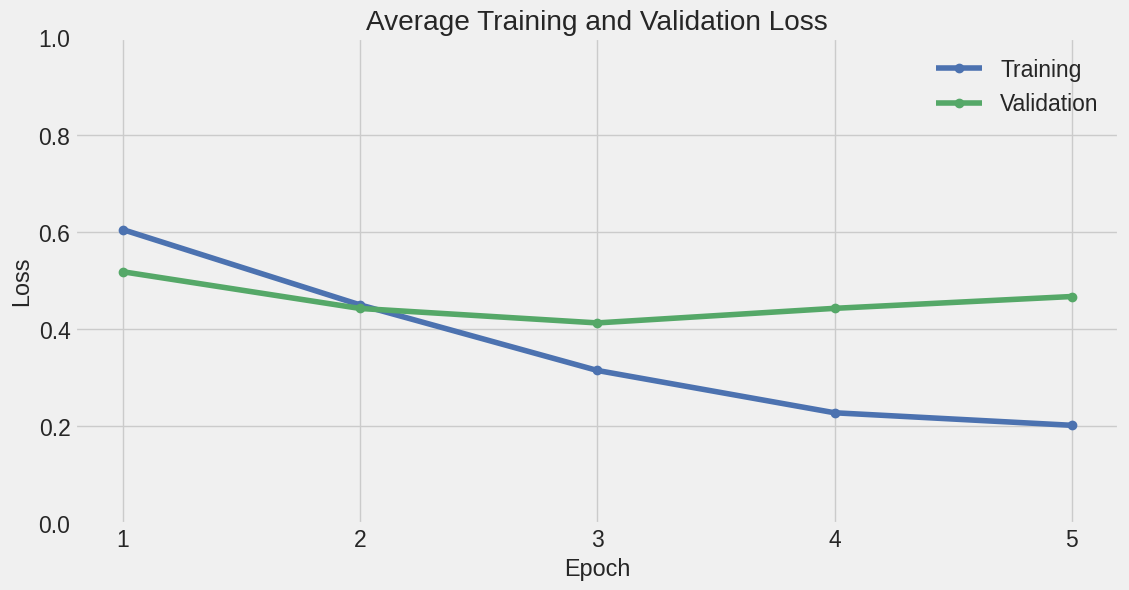

In [ ]:

plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# Labels

plt.title("Average Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))



plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avgloss.eps', format='eps', transparent = True, bbox_inches='tight')

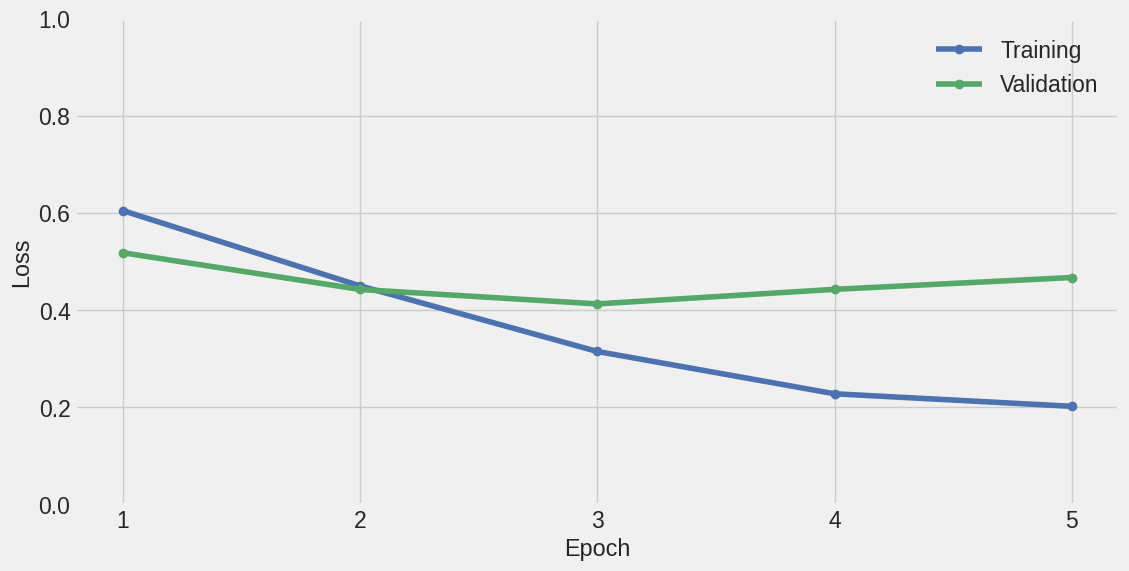

In [ ]:
plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# Labels

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))




plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avglossnoleg.eps', format='eps', transparent = True, bbox_inches='tight')

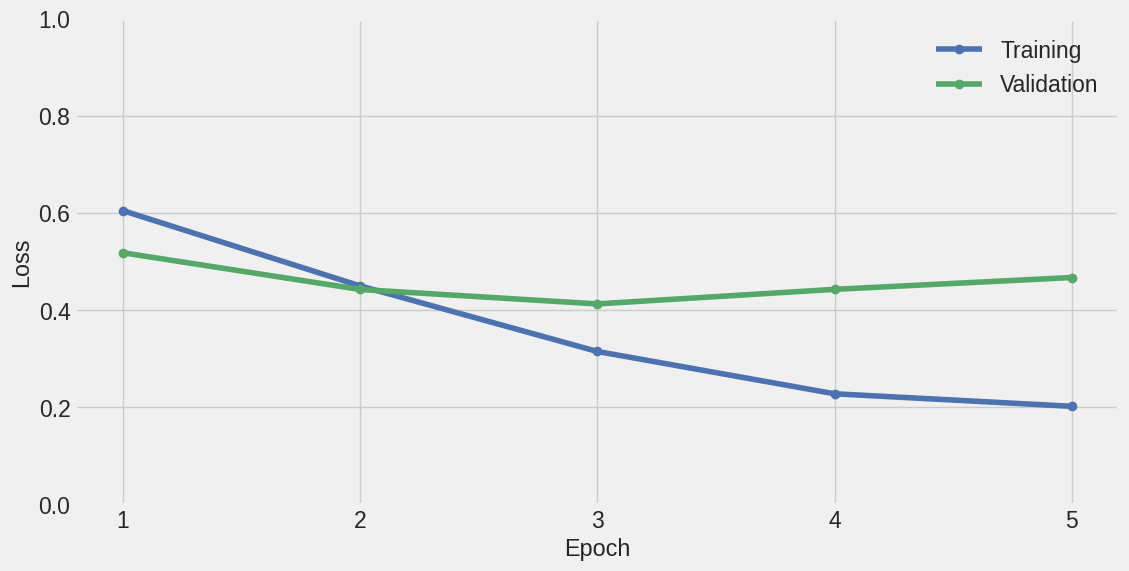

In [ ]:
plt.plot(treino_valid['Training Loss'], 'b-o', label = "Training")
plt.plot(treino_valid['Valid. Loss'], 'g-o', label = "Validation")

# Labels

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((0, 1))




plt.savefig('/content/drive/MyDrive/Projeto Posicionamento COVID/images/2020avglossnoleg.png', format='png', transparent = True, bbox_inches='tight')